In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import matplotlib.pyplot as plt
import torch
from collections import OrderedDict
sys.path.append('..')
sys.path.append('../../simplebev_org/simple_bev')

seed = 41 #/home/mbarin/remote/hpc_run/simplebev_org/simple_bev/nets/tiimnet.py
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

/kuacc/users/mbarin22/.conda/envs/mask2former/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
# prepare arguments class
class Arguments:

    def __init__(self):
        
        self.project = 'mask2former4bev'
        self.model_name = 'mask2former4bev'
        self.dataset_path = '/datasets/nuscenes'
        self.version = 'trainval'

        # write all the parameters like above
        self.res_scale = 1
        self.H = 1600
        self.W = 900
        self.rand_crop_and_resize = 0
        
        self.resize_to = [448,800]
        self.crop_offset = 0
        self.random_flip = 0
        self.resize_lim = [1.0, 1.0]
        self.cams = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
        self.ncams = 6

        self.do_shuffle_cams = 0
        self.refcam_id = 1

        self.backbone = "res101-simplebev"
        self.freeze_backbone = 0
        self.patch_size = 16

        self.mask_classification = 1
        self.class_weight = 1.0
        self.dice_weight = 1.0
        self.mask_weight = 20.0
        self.no_object_weight = 0.1
        self.deep_supervision = 1

        self.train_num_points = 112*112
        self.oversample_ratio = 3.0
        self.importance_sample_ratio = 0.75

        self.sem_seg_head_name = 'mask_former_head'
        self.transformer_in_feature = 'multi_scale_bev_features'

        self.bev_module_name = 'SimpleBEV'
        self.bev_latent_dim = 128
        self.multiscale_feature_channels = [64, 128, 256]
        self.multiscale_feature_norm = 'batch'
        self.multiscale_conv_dim = 256
        self.voxel_size = [200, 8, 200]
        self.bounds = [-50, 50, -5, 5, -50, 50]
        self.do_rgb_compress = 1

        self.use_frozen_bev_feats = 0
        self.frozen_bev_feats_path = '/kuacc/users/mbarin22/hpc_run/mask2former4bev/checkpoints/simplebev/8x5_5e-4_rgb12_22:43:46/model-000025000.pth'

        self.num_classes = 1

        self.predictor_type = 'TransformerPredictor'
        self.nheads = 8
        self.dec_layers = 6
        self.pe_hidden_dim = 256
        self.predictor_dropout = 0
        self.num_queries = 100
        self.pre_norm = 0
        self.dim_feedforward = 2048
        self.enforce_input_project = 0
        self.mask_dim = 256
        
        self.use_multiscale_features = 1
        self.rt_regression = 1
        self.translation_weight =1
        self.heading_weight = 1

        self.use_lidar = 1

        self.decoder_type = 'conv'

        self.learning_rate = 4e-4
        self.weight_decay = 1e-7
        self.dropout = 0.0


args = Arguments()

In [33]:
# ckpt_path = '/kuacc/users/mbarin22/hpc_run/mask2former4bev/scripts/model.pth'
#checkpoints/[224, 448]_randcrop:0_shufflecams:0_randflip:0_backbone:res101-simplebev-0_cls:1_pts:12544_bevfeats:0_2kk_0.0003_exp_conv-modules/best.pt

simplebev_ckpt_path = "/kuacc/users/mbarin22/hpc_run/mask2former4bev/checkpoints/simplebev/8x5_5e-4_rgb12_22:43:46/model-000025000.pth"
ckpt_path = "/kuacc/users/mbarin22/hpc_run/mask2former4bev/checkpoints/[448, 800]_bs:16_nq:100_randcrop:0_shufflecams:0_randflip:0_backbone:res101-simplebev-0_cls:1_rt_pix_center-size:1_pts:12544_bevfeats:0_20k_0.0001_do:0_exp_conv-modules/best.pt" #/[448, 800]_bs:16_nq:100_randcrop:0_shufflecams:0_randflip:0_backbone:res101-simplebev-0_cls:1_rt_pix_center-size:1_pts:12544_bevfeats:0_20k_0.0001_do:0_exp_conv-modules/best.pt" #"-

In [5]:
from dataset import NuScenesDatasetWrapper

datamodule = NuScenesDatasetWrapper(args)

Loading NuScenes version trainval from /datasets/nuscenes
Done loading NuScenes version trainval


In [36]:
from models.mask2former4bev import Mask2Former4BEV

model = Mask2Former4BEV(args).cuda()
loaded_model = OrderedDict((key.replace('module.', ''), value) for key, value in torch.load(ckpt_path)["model"].items()) 

model.load_state_dict(loaded_model,strict=True)
model.eval()

idx: 0, in_channels: 64
idx: 1, in_channels: 128
idx: 2, in_channels: 256
lateral_convs 0: None
lateral_convs 1: Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
lateral_convs 2: Sequential(
  (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
output_convs 0: Sequential(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
output_convs 1: Sequential(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
output_convs 2: Sequential(
  (0): Conv2d(256, 256, kernel_size

Mask2Former4BEV(
  (backbone): SimpleBEVEncoder(
    (encoder): Encoder_res101(
      (backbone): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tru

In [13]:
from models.bev_module.segnet import Segnet
from utils_.vox import Vox_util
import numpy as np

# the scene centroid is defined wrt a reference camera,
# which is usually random
scene_centroid_x = 0.0
scene_centroid_y = 1.0 # down 1 meter
scene_centroid_z = 0.0

scene_centroid_py = np.array([scene_centroid_x,
                            scene_centroid_y,
                            scene_centroid_z]).reshape([1, 3])
scene_centroid = torch.from_numpy(scene_centroid_py).float().cuda()

vox_util = Vox_util(
                    Z=200,
                    Y=8,
                    X=200,
                    scene_centroid=scene_centroid.cuda(),
                    bounds=args.bounds,
                    assert_cube=False
                    )

simple_model = Segnet(Z=200,
                        Y=8,
                        X=200,
                        vox_util=vox_util
                         ).cuda()

loaded_model = torch.load(simplebev_ckpt_path)['model_state_dict']
#loaded_model = OrderedDict((key.replace('module.', ''), value) for key, value in torch.load(simplebev_ckpt_path)["model_state_dict"].items()) 

simple_model.load_state_dict(loaded_model)
simple_model.eval()

Segnet(
  (encoder): Encoder_res101(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
   

In [12]:
def batch_inputs(key, batched_inputs):
    inp = [x[key] for x in batched_inputs]
    inp = torch.stack(inp, dim=0)
    return inp


from utils_.geom import *
from utils_.basic import *

def simple_pass(batch, model):
    
    dataset_dict = batch
    
    imgs = batch_inputs('images', dataset_dict).cuda() #to(device)      # B, N, C, H, W
    rots = batch_inputs('rots', dataset_dict).cuda() #.to(device)        # B, N, 3, 3
    trans = batch_inputs('trans', dataset_dict).cuda() #.to(device)      # B, N, 3
    intrins = batch_inputs('intrins', dataset_dict).cuda() #.to(device)  # B, N, 4, 4
    seg_bev_g = batch_inputs('seg_bev', dataset_dict).cuda() #.to(device) # B, N, 2, H, W
    valid_bev_g = batch_inputs('valid_bev', dataset_dict).cuda() #.to(device) # B, N, 1, H, W
    center_bev_g = batch_inputs('center_bev', dataset_dict).cuda() #.to(device) # B, N, 2, H, W
    offset_bev_g = batch_inputs('offset_bev', dataset_dict).cuda() #.to(device) # B, N, 2, H, W
    
    rgb_camXs = imgs.float().cuda() #.to(device)
    rgb_camXs = rgb_camXs - 0.5 # go to -0.5, 0.5

    seg_bev_g = seg_bev_g.cuda() #.to(device)
    valid_bev_g = valid_bev_g.cuda() #.to(device)
    center_bev_g = center_bev_g.cuda() #.to(device)
    offset_bev_g = offset_bev_g.cuda() #.to(device)

    B, S, C, H, W = rgb_camXs.shape

    __p = lambda x: pack_seqdim(x, B)
    __u = lambda x: unpack_seqdim(x, B)


    intrins_ = __p(intrins)
    pix_T_cams_ = merge_intrinsics(*split_intrinsics(intrins_)).cuda() #.to(device)
    pix_T_cams = __u(pix_T_cams_)

    velo_T_cams = merge_rtlist(rots, trans).cuda()
    cams_T_velo = __u(safe_inverse(__p(velo_T_cams)))
    
    cam0_T_camXs = get_camM_T_camXs(velo_T_cams, ind=0)
    camXs_T_cam0 = __u(safe_inverse(__p(cam0_T_camXs)))
    cam0_T_camXs_ = __p(cam0_T_camXs)
    camXs_T_cam0_ = __p(camXs_T_cam0)
    vox_util = Vox_util(
        Z=200, Y=8, X=200,
        scene_centroid=scene_centroid.cuda(),
        bounds=args.bounds,
        assert_cube=False)
    
    #if not (model.module.use_radar or model.module.use_lidar):
    in_occ_mem0 = None
    cam0_T_camXs = cam0_T_camXs

    # lrtlist_cam0_g = lrtlist_cam0

    out  = model(
            rgb_camXs=rgb_camXs,
            pix_T_cams=pix_T_cams,
            cam0_T_camXs=cam0_T_camXs,
            vox_util=vox_util,
            rad_occ_mem0=in_occ_mem0)
    
    return out['segmentation']

In [8]:
valset = datamodule.val()

is_train False


In [10]:
import pickle
with open('saved_dictionary.pkl', 'rb') as handle:
    indices =  pickle.load(handle)


In [15]:
k_indices = sorted(indices.items(), key=lambda x:x[1])
k_indices = dict(k_indices)
k_indices

{4: -0.018710565567016613,
 3: -0.018521711230278015,
 2: -0.015713870525360107,
 5: -0.014659687876701355,
 1: -0.011496901512145996,
 14: -0.010511012872060133,
 6: -0.009588556630270861,
 15: -0.008700592443346977,
 7: -0.006495378911495209,
 13: -0.006095620138304614,
 0: -0.004996269941329956,
 16: -0.003661125898361206,
 12: -0.0030699097193204183,
 17: -0.002167251374986412,
 8: -0.0013032986058129081,
 18: 0.0012317739034953812,
 19: 0.001408943533897422,
 20: 0.0016511025882902097,
 11: 0.0035980989535649988,
 10: 0.006081632592461306,
 9: 0.006584239006042492,
 21: 0.008106426759199648,
 22: 0.008790141862371648,
 23: 0.01541074737906456,
 24: 0.01975391387939457,
 154: 0.019939207117403712,
 153: 0.02003648552995224,
 151: 0.02027487975398179,
 149: 0.0204109766582648,
 155: 0.02048771260067439,
 152: 0.020519553689785253,
 150: 0.020718928451174956,
 147: 0.02075719012803323,
 156: 0.020816752343041145,
 157: 0.020870855195990135,
 158: 0.021029636404424346,
 146: 0.0211317

In [11]:
s_indices = sorted(indices.items(), key=lambda x:x[1], reverse=True)
s_indices = dict(s_indices)
s_indices

{2087: 0.08319659452435785,
 2086: 0.0831931618519331,
 2084: 0.08316250074502946,
 2088: 0.0831570795627089,
 2093: 0.08315535971170795,
 2077: 0.08315095711137321,
 2085: 0.08314852830654768,
 2076: 0.08314630575567755,
 2083: 0.08314096179545899,
 2073: 0.0831394144383294,
 2078: 0.08313675914828794,
 2074: 0.08313448042575133,
 2075: 0.08312986600024336,
 2072: 0.0831271178078749,
 2079: 0.0831251620798587,
 2080: 0.08311260939324666,
 2071: 0.08310855017313334,
 2082: 0.08310791054419525,
 2092: 0.0831024784148024,
 2081: 0.08310015785698416,
 2070: 0.08308825996051888,
 2094: 0.08308654342709121,
 2069: 0.08308189652212289,
 2089: 0.08305555342308929,
 2068: 0.08304941397630228,
 2091: 0.08304779751343838,
 2067: 0.08301349443778022,
 2090: 0.08301200905288314,
 2066: 0.08298299282998295,
 2065: 0.08296349622842941,
 2064: 0.08295757246472069,
 1871: 0.08294117467231155,
 1880: 0.08293934113948603,
 2095: 0.08292853204401934,
 2063: 0.08292568139840178,
 1872: 0.08291664720178288

torch.Size([200, 200])


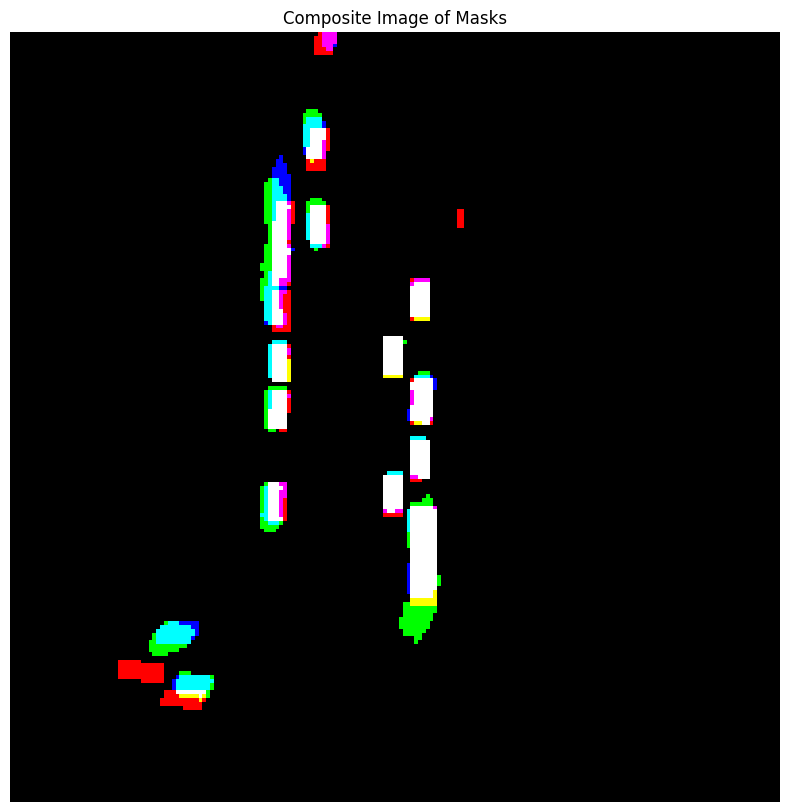

In [14]:
idx = 2087
batch = valset[idx]
preds = model([batch], training=False)  # a dictionary of losses
our_pred = (preds[0]['pred_masks']> 0.5).detach().cpu()

simple_preds = simple_pass([batch], simple_model)
simple_pred = simple_preds.detach().cpu()[0].sigmoid().round()

import matplotlib.pyplot as plt
import numpy as np

# Sample binary masks
ground_truth = (batch['gt_masks'].cpu()*batch['gt_valid'].cpu())[0]
model_pred_1 = our_pred[0]
model_pred_2 = simple_pred[0]

print(ground_truth.shape)

# Creating an empty image with 3 channels (RGB)
composite_image = np.zeros((ground_truth.shape[0], ground_truth.shape[1], 3), dtype=np.uint8)

# Assigning each mask to a different channel (R, G, B)
composite_image[:, :, 0] = ground_truth * 255  # Red channel for ground truth
composite_image[:, :, 1] = model_pred_1 * 255  # Green channel for first model prediction
composite_image[:, :, 2] = model_pred_2 * 255  # Blue channel for second model prediction

# Display the composite image
plt.figure(figsize=(10, 10))
plt.imshow(composite_image)
plt.title('Composite Image of Masks')
plt.axis('off')  # Hide axis
plt.show()
        

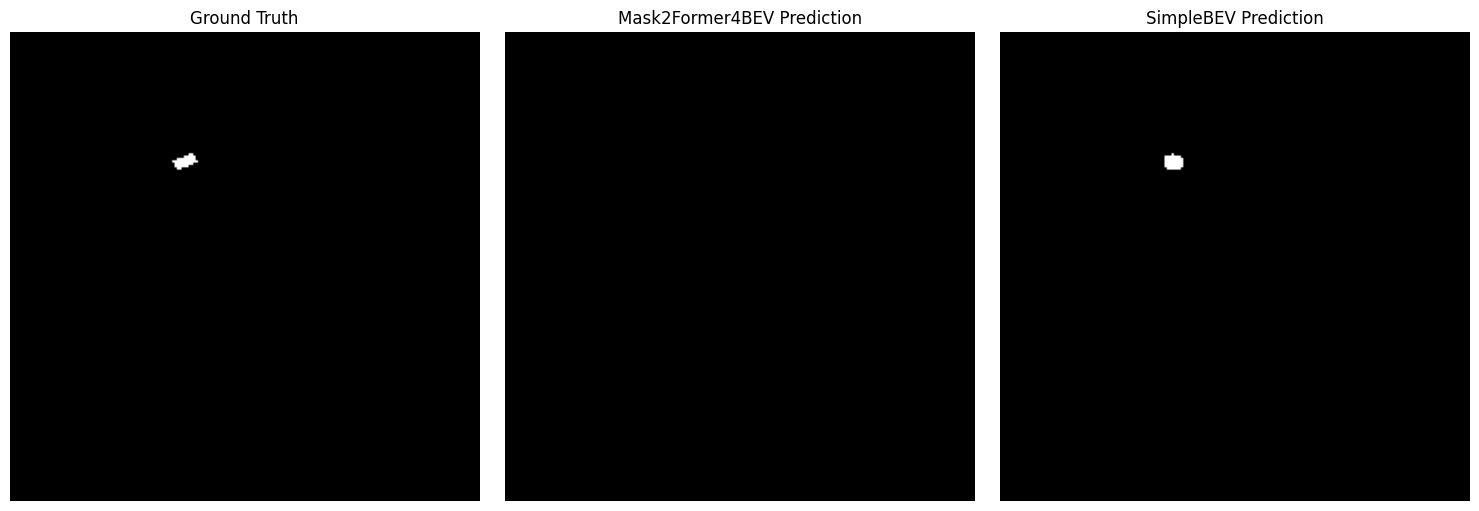

In [19]:
idx = 2833
batch = valset[idx]
preds = model([batch], training=False)  # a dictionary of losses
our_pred = (preds[0]['pred_masks']> 0.5).detach().cpu()

simple_preds = simple_pass([batch], simple_model)
simple_pred = simple_preds.detach().cpu()[0].sigmoid().round()

import matplotlib.pyplot as plt
import numpy as np

# Sample binary masks
ground_truth = (batch['gt_masks'].cpu())[0] #*batch['gt_valid'].cpu())[0]
model_pred_1 = our_pred[0]
model_pred_2 = simple_pred[0]

# Create a figure with 3 subplots, side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Ground Truth
axes[0].imshow(ground_truth, cmap='gray')
axes[0].set_title('Ground Truth')
axes[0].axis('off')  # Remove axis ticks and labels

# Plot First Model Prediction
axes[1].imshow(model_pred_1, cmap='gray')
axes[1].set_title('Mask2Former4BEV Prediction')
axes[1].axis('off')  # Remove axis ticks and labels

# Plot Second Model Prediction
axes[2].imshow(model_pred_2, cmap='gray')
axes[2].set_title('SimpleBEV Prediction')
axes[2].axis('off')  # Remove axis ticks and labels

plt.tight_layout()
plt.show()


In [9]:
idx = 2087
sample = valset[idx]

In [10]:
sample['images'].shape

torch.Size([6, 3, 448, 800])

In [11]:
preds = model([sample]) 

[(tensor([ 2,  3,  6, 10, 14, 15, 21, 29, 30, 34, 43, 50, 62, 78, 81, 83, 89, 92]), tensor([ 4,  2, 10,  5,  1,  9,  7, 13, 16, 15, 12, 14,  0, 17,  3, 11,  8,  6]))]
src_rt :  tensor([[ 88.3711,  24.1401,   4.1414,   9.3495,  -0.9773],
        [ 63.8455,  66.2626,   3.7348,   9.2189,  -1.0735],
        [ 70.9716,  97.3024,   3.5286,  10.4992,  -0.3691],
        [106.2172, 131.9824,   7.1325,  14.6677,   2.4898],
        [ 45.5304, 143.0378,   5.8794,   5.5583,   0.5054],
        [104.4261,  65.2066,   3.6608,  10.0421,   2.0809],
        [105.2383,  94.2167,   5.1346,  11.3126,   2.3796],
        [ 80.9868,  51.3876,   3.5209,   8.3367,   1.8897],
        [ 69.3810, 121.0028,   3.8939,  10.5276,  -0.7589],
        [ 83.4354,  90.3255,   2.9275,   4.3226,   1.4570],
        [ 77.7614,  96.8799,   4.9279,   6.6648,   2.2352],
        [ 71.8204,  50.9671,   4.1166,   8.5248,  -0.7993],
        [106.1697, 110.8554,   4.0311,  10.5438,   2.6274],
        [ 67.2296,  55.2725,   4.2131,   9.

In [60]:
preds[0]['pred_rt'], batch['translation_rotation_list']

(tensor([[-3.0064e+01, -2.7720e-01,  1.1839e+00,  2.6492e+00],
         [ 6.7337e+00, -4.5499e-01,  7.8222e-01,  2.3052e+00],
         [-2.0846e+01, -4.1347e-01,  4.3170e-01,  5.3617e+00],
         [ 8.1102e-01, -5.4291e-01,  5.4587e-01,  4.8613e+00],
         [-1.4231e+01, -5.4561e-01,  1.0134e+00,  1.8305e+00],
         [-2.0097e+01, -3.6029e-01,  4.4405e-01,  5.6015e+00],
         [-1.9594e+01, -4.2205e-01,  4.6789e-01,  5.1986e+00],
         [ 9.6657e+00, -8.2091e-01,  3.3988e-01, -2.5185e-02],
         [-2.7444e+01, -6.5868e-01,  7.5784e-01,  2.3402e+00],
         [-3.7368e+01, -5.5163e-01,  5.8349e-01,  1.4624e+00],
         [-1.1561e+01, -3.4306e-01,  5.8131e-01,  5.4544e+00],
         [-1.1151e+01, -1.5837e-01,  6.2419e-01,  5.3938e+00],
         [ 2.0651e+01, -9.2026e-01,  5.1712e-01,  2.4872e+00],
         [-3.5204e+01, -5.3263e-01,  9.1228e-01,  4.3425e+00],
         [ 1.8852e+01, -2.3515e-01,  1.3831e+00,  1.7317e+00],
         [ 1.9520e+01, -7.5912e-01,  5.0364e-01,  3.197

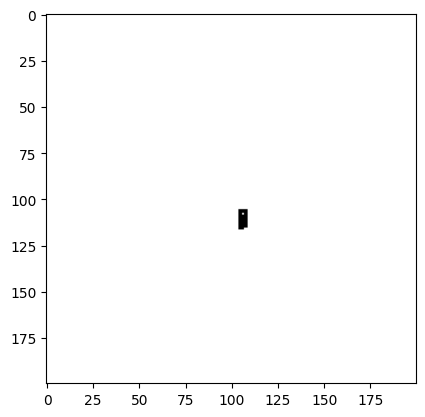

In [42]:
batch['multi_seg_bev'][0][108,106] = 0
plt.imshow(batch['multi_seg_bev'][0], cmap='binary')

-49.308747848958646


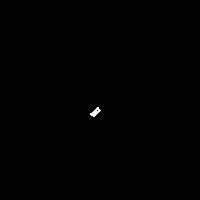

In [49]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import math
import torchvision.transforms.functional as F

image_tensor = batch['multi_seg_bev'][0].unsqueeze(0)

# Specify your rotation angle in radians here
angle_radians = -0.8606  # For example, 45 degrees in radians

# Convert radians to degrees since PyTorch's rotate function uses degrees
angle_degrees = angle_radians * (180 / math.pi)
print(angle_degrees)

rotated_image_tensor = F.rotate(image_tensor, angle_degrees)

# To display or save the rotated image, you may need to convert it back to a PIL image
to_pil = transforms.ToPILImage()
rotated_image = to_pil(rotated_image_tensor)
rotated_image.show() # Uncomment to display the image

# Note: Depending on what you want to do with the rotated image (e.g., saving, displaying),
# you may need to convert it back to a PIL image or handle it differently.


In [51]:
preds[0]['pred_rt'][  [1,   3,  11,  14,  18,  22,  24,  39,  46,  65,  71,  75,  82,  91, 92,  95,  96,  97,  98, 100, 101, 103],:]

tensor([[  6.7337,  -0.4550,   0.7822,   2.3052],
        [  0.8110,  -0.5429,   0.5459,   4.8613],
        [-11.1509,  -0.1584,   0.6242,   5.3938],
        [ 18.8523,  -0.2351,   1.3831,   1.7317],
        [-35.6141,  -0.6830,   0.9675,   4.1908],
        [ -5.9286,   0.1240,   0.6047,   5.2727],
        [-32.0839,  -0.6874,   0.5601,   1.5524],
        [  8.6209,  -0.3860,   0.2673,   1.0215],
        [-34.7955,   0.4226,   0.8457,   1.1897],
        [-20.2181,  -0.4307,   0.8144,   5.9354],
        [-44.8867,   0.3172,   0.8657,   1.0843],
        [-13.5221,  -0.7832,   1.0704,   1.5853],
        [ 32.3986,  -1.0387,   0.5372,   0.7773],
        [-23.5993,  -0.2640,   0.7213,   5.5510],
        [ 12.9980,  -0.2177,   0.7374,   5.2553],
        [ 11.1542,  -1.2300,   0.9224,   2.2504],
        [ -0.1591,  -0.3250,   0.9462,   1.9588],
        [-35.1936,   0.4957,   0.8195,   1.0839],
        [-35.3611,   0.6253,   0.7718,   1.9785],
        [-17.0051,  -0.3914,   0.7153,   5.6745],


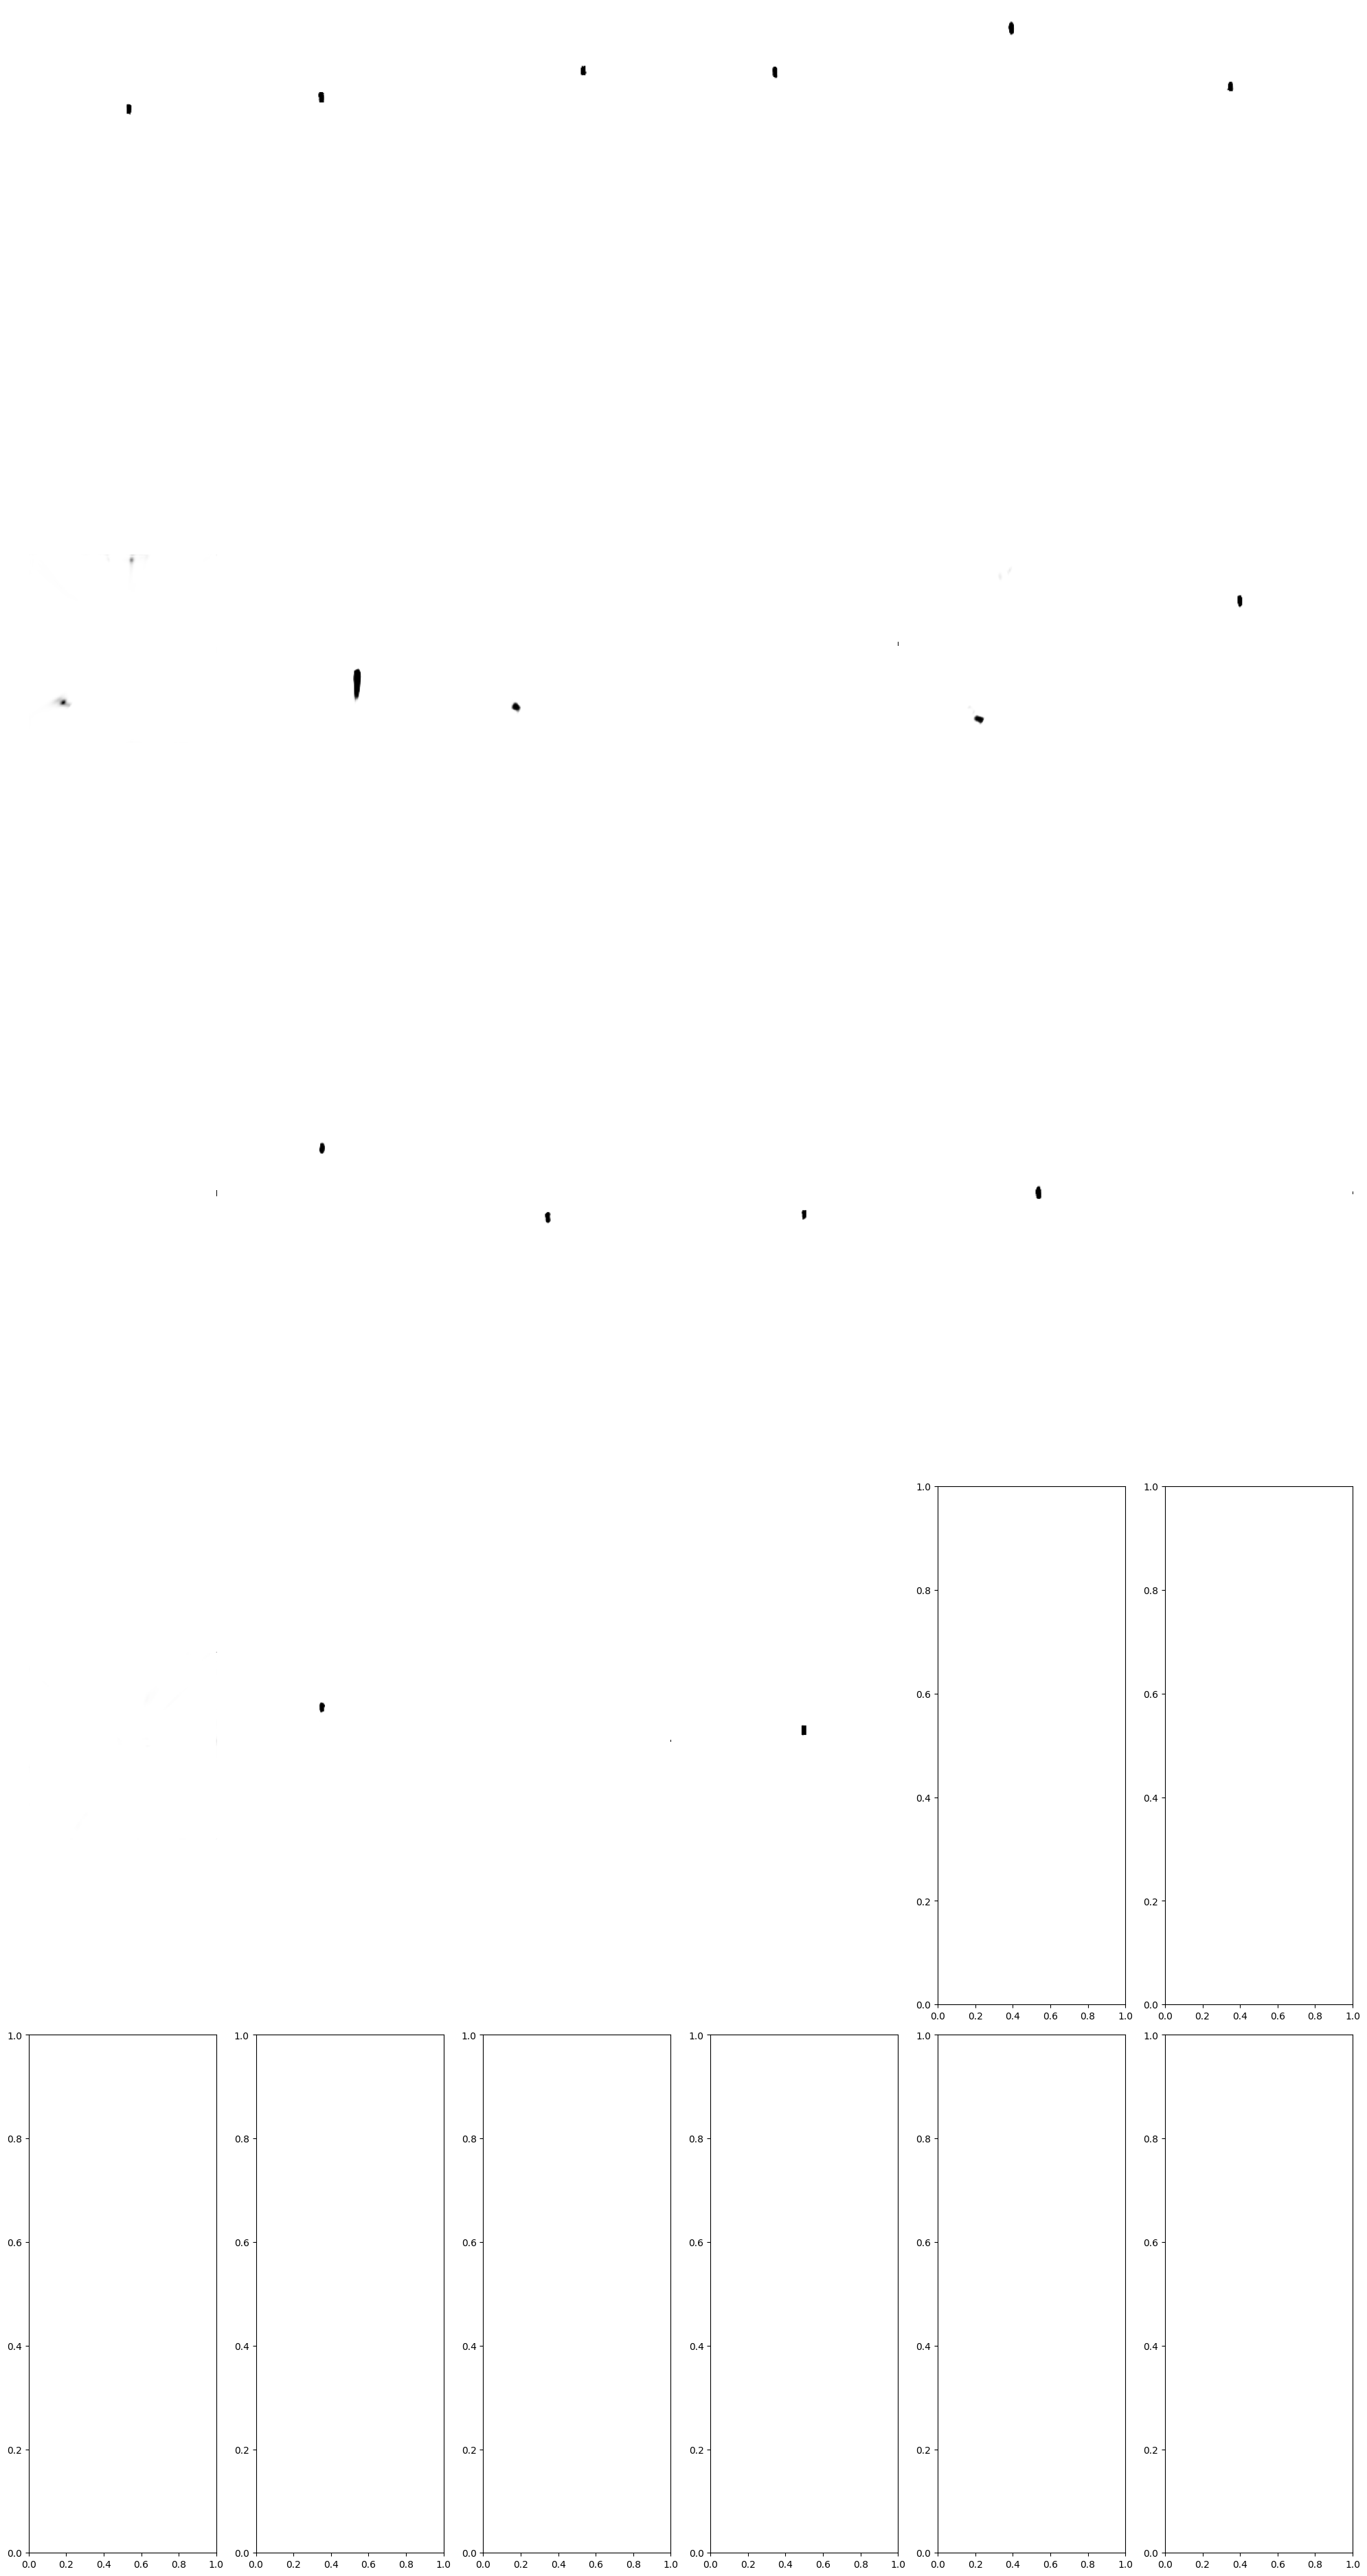

In [19]:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 6, figsize=(20, 40))


axes = axes.flatten()
masks = preds[0]['pred_query'][  [  1,   3,   4,  11,  18,  22,  24,  28,  39,  46,  59,  65,  84,  91,
         92,  95,  96,  97,  98, 100, 101, 103],:]
# Iterate through the masks and plot them
for i in range(len(masks)):
    # Get the current mask
    mask = masks[i].sigmoid().detach().cpu()

    # Get the current axis
    ax = axes[i]

    # Plot the mask
    ax.imshow(mask, cmap='binary')

    # Turn off axis labels
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [38]:
class Evaluator:
    def __init__(self):
        self.reset()

    def reset(self):
        print("Resetting Evaluator")
        self.mious = []

    def calculate_miou(self, pred, gt, valid):
        
        pred_round = (pred > 0.9).float()  
        if valid is None:
            valid = torch.ones_like(gt)
            
        intersection = (pred_round*gt*valid).sum(dim=[1,2])
        union = ((pred_round+gt)*valid).clamp(0,1).sum(dim=[1,2])
        iou = (intersection/(1e-4 + union)).mean()

        # batch mean
        self.mious.append(iou.item())

    
    def update(self, pred, gt, valid=None):

        self.calculate_miou(pred, gt, valid)

        last_miou = self.mious[-1]

        results = self.get_results(reset=False)

        results['last_mIoU'] = last_miou

        return results

    def get_results(self, reset=True):

        miou = sum(self.mious) / len(self.mious)

        if reset:
            self.reset()
        
        return {'mIoU' : miou}
    


In [39]:
from evaluator import SimpleEvaluator

def custom_collate_fn(batch):
    return batch

our_evaluator = Evaluator() 
simple_evaluator = SimpleEvaluator()

from tqdm import tqdm
valset_  = tqdm(range(len(valset)))

set_diff = {}

for i in valset_: #list(s_indices.keys())[:100]: #enumerate(val_loader):  #valset_: #
    
    batch = valset[i]

    preds = model([batch], training=False)  # a dictionary of losses

    simple_preds = simple_pass([batch], simple_model)


    for idx, pred in enumerate(preds):
        pred_masks = pred['pred_masks'].detach().cpu()
        gt_masks = batch['gt_masks'].cpu()
        valid_masks = batch['gt_valid'].cpu()
        simple_masks = simple_preds.detach().cpu()[0]


        assert pred_masks.shape == (1, 200, 200)
        assert gt_masks.shape == (1, 200, 200)
        assert valid_masks.shape == (1, 200, 200)
        assert simple_masks.shape == (1, 200, 200)

        # ===  Segmentation Evaluation ===
        us_miou = our_evaluator.update(pred_masks, gt_masks, valid_masks)
        miou = us_miou['mIoU']
        last_miou = us_miou['last_mIoU']

        simple_miou = simple_evaluator.update(simple_masks, gt_masks, valid_masks)
        s_miou = simple_miou['mIoU']
        s_last_miou = simple_miou['last_mIoU']

        set_diff[i] = s_last_miou - last_miou

        '''
        # Model predictions
        model_pred_1 =  (pred_masks[0]> 0.9).detach().cpu()
        model_pred_2 = simple_masks.detach().cpu()[0].sigmoid().round()
        ground_truth = (batch['gt_masks'].cpu()*batch['gt_valid'].cpu())[0]


        # Composite Image
        composite_image = np.zeros((ground_truth.shape[0], ground_truth.shape[1], 3), dtype=np.uint8)
        composite_image[:, :, 0] = ground_truth * 255  # Red channel for ground truth
        composite_image[:, :, 1] = model_pred_1 * 255  # Green channel for first model prediction
        composite_image[:, :, 2] = model_pred_2 * 255  # Blue channel for second model prediction

        # Plotting
        fig, axes = plt.subplots(1, 4, figsize=(15, 15))

        # Composite Image
        axes[0].imshow(composite_image)
        axes[0].set_title('Composite Image of Masks')
        axes[0].axis('off')

        # Ground Truth
        axes[1].imshow(ground_truth, cmap='gray')
        axes[1].set_title('Ground Truth')
        axes[1].axis('off')

        # First Model Prediction
        axes[2].imshow(model_pred_1, cmap='gray')
        axes[2].set_title('Mask2Former4BEV Prediction')
        axes[2].axis('off')

        # Second Model Prediction
        axes[3].imshow(model_pred_2, cmap='gray')
        axes[3].set_title('SimpleBEV Prediction')
        axes[3].axis('off')

        plt.tight_layout()
        plt.savefig(f'center-size-err-th-0.9/{i}_err:{set_diff[i]* 100:.2f}_us:{last_miou* 100:.2f}_simple:{s_last_miou* 100:.2f}.png', dpi=300)
        plt.show()
        #print(set_diff[idx])
        '''
        
    metric_desc = f"mIoU: {miou * 100:.3f} | simple mIoU: {s_miou * 100:.3f}"
    # === Logger ===
    valset_.set_description(metric_desc)



        
import pickle 
with open('center-size-err-th-0.9.pkl', 'wb') as f:
    pickle.dump(set_diff, f)       

Resetting Evaluator
Resetting Evaluator



mIoU: 26.796 | simple mIoU: 64.206:   0%|                                                                                                                                         | 0/6019 [39:20<?, ?it/s]

mIoU: 50.588 | simple mIoU: 42.922:   0%|                                                                                                                                         | 0/6019 [00:00<?, ?it/s]
mIoU: 50.588 | simple mIoU: 42.922:   0%|                                                                                                                                 | 1/6019 [00:00<37:39,  2.66it/s]
mIoU: 49.781 | simple mIoU: 42.037:   0%|                                                                                                                                 | 1/6019 [00:00<37:39,  2.66it/s]
mIoU: 49.781 | simple mIoU: 42.037:   0%|                                                                                                                                 | 2/6019 [00

mIoU: 41.971 | simple mIoU: 44.920:   1%|▊                                                                                                                               | 39/6019 [00:14<35:01,  2.85it/s]
mIoU: 41.892 | simple mIoU: 45.012:   1%|▊                                                                                                                               | 39/6019 [00:14<35:01,  2.85it/s]
mIoU: 41.892 | simple mIoU: 45.012:   1%|▊                                                                                                                               | 40/6019 [00:14<35:05,  2.84it/s]
mIoU: 41.886 | simple mIoU: 45.075:   1%|▊                                                                                                                               | 40/6019 [00:14<35:05,  2.84it/s]
mIoU: 41.886 | simple mIoU: 45.075:   1%|▊                                                                                                                               | 41/6019 [00:1

mIoU: 46.245 | simple mIoU: 50.314:   1%|█▋                                                                                                                              | 78/6019 [00:28<35:23,  2.80it/s]
mIoU: 46.658 | simple mIoU: 50.699:   1%|█▋                                                                                                                              | 78/6019 [00:28<35:23,  2.80it/s]
mIoU: 46.658 | simple mIoU: 50.699:   1%|█▋                                                                                                                              | 79/6019 [00:28<35:20,  2.80it/s]
mIoU: 47.107 | simple mIoU: 51.088:   1%|█▋                                                                                                                              | 79/6019 [00:29<35:20,  2.80it/s]
mIoU: 47.107 | simple mIoU: 51.088:   1%|█▋                                                                                                                              | 80/6019 [00:2

mIoU: 47.082 | simple mIoU: 48.592:   2%|██▍                                                                                                                            | 117/6019 [00:42<34:58,  2.81it/s]
mIoU: 46.975 | simple mIoU: 48.648:   2%|██▍                                                                                                                            | 117/6019 [00:42<34:58,  2.81it/s]
mIoU: 46.975 | simple mIoU: 48.648:   2%|██▍                                                                                                                            | 118/6019 [00:42<35:11,  2.80it/s]
mIoU: 46.988 | simple mIoU: 48.439:   2%|██▍                                                                                                                            | 118/6019 [00:42<35:11,  2.80it/s]
mIoU: 46.988 | simple mIoU: 48.439:   2%|██▌                                                                                                                            | 119/6019 [00:4

mIoU: 46.522 | simple mIoU: 47.206:   3%|███▎                                                                                                                           | 156/6019 [00:55<33:46,  2.89it/s]
mIoU: 46.596 | simple mIoU: 47.368:   3%|███▎                                                                                                                           | 156/6019 [00:56<33:46,  2.89it/s]
mIoU: 46.596 | simple mIoU: 47.368:   3%|███▎                                                                                                                           | 157/6019 [00:56<33:46,  2.89it/s]
mIoU: 46.683 | simple mIoU: 47.470:   3%|███▎                                                                                                                           | 157/6019 [00:56<33:46,  2.89it/s]
mIoU: 46.683 | simple mIoU: 47.470:   3%|███▎                                                                                                                           | 158/6019 [00:5

mIoU: 45.238 | simple mIoU: 47.304:   3%|████                                                                                                                           | 195/6019 [01:09<35:07,  2.76it/s]
mIoU: 45.093 | simple mIoU: 47.171:   3%|████                                                                                                                           | 195/6019 [01:10<35:07,  2.76it/s]
mIoU: 45.093 | simple mIoU: 47.171:   3%|████▏                                                                                                                          | 196/6019 [01:10<35:05,  2.77it/s]
mIoU: 44.995 | simple mIoU: 47.106:   3%|████▏                                                                                                                          | 196/6019 [01:10<35:05,  2.77it/s]
mIoU: 44.995 | simple mIoU: 47.106:   3%|████▏                                                                                                                          | 197/6019 [01:1

mIoU: 45.915 | simple mIoU: 48.531:   4%|████▉                                                                                                                          | 234/6019 [01:23<33:56,  2.84it/s]
mIoU: 45.883 | simple mIoU: 48.504:   4%|████▉                                                                                                                          | 234/6019 [01:23<33:56,  2.84it/s]
mIoU: 45.883 | simple mIoU: 48.504:   4%|████▉                                                                                                                          | 235/6019 [01:23<33:55,  2.84it/s]
mIoU: 45.804 | simple mIoU: 48.401:   4%|████▉                                                                                                                          | 235/6019 [01:24<33:55,  2.84it/s]
mIoU: 45.804 | simple mIoU: 48.401:   4%|████▉                                                                                                                          | 236/6019 [01:2

mIoU: 46.728 | simple mIoU: 49.450:   5%|█████▊                                                                                                                         | 273/6019 [01:37<34:43,  2.76it/s]
mIoU: 46.717 | simple mIoU: 49.441:   5%|█████▊                                                                                                                         | 273/6019 [01:37<34:43,  2.76it/s]
mIoU: 46.717 | simple mIoU: 49.441:   5%|█████▊                                                                                                                         | 274/6019 [01:37<34:44,  2.76it/s]
mIoU: 46.706 | simple mIoU: 49.438:   5%|█████▊                                                                                                                         | 274/6019 [01:38<34:44,  2.76it/s]
mIoU: 46.706 | simple mIoU: 49.438:   5%|█████▊                                                                                                                         | 275/6019 [01:3

mIoU: 46.037 | simple mIoU: 49.463:   5%|██████▌                                                                                                                        | 312/6019 [01:51<34:13,  2.78it/s]
mIoU: 46.003 | simple mIoU: 49.439:   5%|██████▌                                                                                                                        | 312/6019 [01:52<34:13,  2.78it/s]
mIoU: 46.003 | simple mIoU: 49.439:   5%|██████▌                                                                                                                        | 313/6019 [01:52<34:17,  2.77it/s]
mIoU: 45.980 | simple mIoU: 49.412:   5%|██████▌                                                                                                                        | 313/6019 [01:52<34:17,  2.77it/s]
mIoU: 45.980 | simple mIoU: 49.412:   5%|██████▋                                                                                                                        | 314/6019 [01:5

mIoU: 45.767 | simple mIoU: 49.240:   6%|███████▍                                                                                                                       | 351/6019 [02:05<35:02,  2.70it/s]
mIoU: 45.777 | simple mIoU: 49.254:   6%|███████▍                                                                                                                       | 351/6019 [02:06<35:02,  2.70it/s]
mIoU: 45.777 | simple mIoU: 49.254:   6%|███████▍                                                                                                                       | 352/6019 [02:06<34:58,  2.70it/s]
mIoU: 45.794 | simple mIoU: 49.296:   6%|███████▍                                                                                                                       | 352/6019 [02:06<34:58,  2.70it/s]
mIoU: 45.794 | simple mIoU: 49.296:   6%|███████▍                                                                                                                       | 353/6019 [02:0

mIoU: 44.686 | simple mIoU: 48.398:   6%|████████▏                                                                                                                      | 390/6019 [02:19<32:57,  2.85it/s]
mIoU: 44.676 | simple mIoU: 48.420:   6%|████████▏                                                                                                                      | 390/6019 [02:20<32:57,  2.85it/s]
mIoU: 44.676 | simple mIoU: 48.420:   6%|████████▎                                                                                                                      | 391/6019 [02:20<32:52,  2.85it/s]
mIoU: 44.680 | simple mIoU: 48.428:   6%|████████▎                                                                                                                      | 391/6019 [02:20<32:52,  2.85it/s]
mIoU: 44.680 | simple mIoU: 48.428:   7%|████████▎                                                                                                                      | 392/6019 [02:2

mIoU: 44.047 | simple mIoU: 47.490:   7%|█████████                                                                                                                      | 429/6019 [02:33<34:26,  2.71it/s]
mIoU: 44.064 | simple mIoU: 47.501:   7%|█████████                                                                                                                      | 429/6019 [02:34<34:26,  2.71it/s]
mIoU: 44.064 | simple mIoU: 47.501:   7%|█████████                                                                                                                      | 430/6019 [02:34<34:18,  2.71it/s]
mIoU: 44.045 | simple mIoU: 47.532:   7%|█████████                                                                                                                      | 430/6019 [02:34<34:18,  2.71it/s]
mIoU: 44.045 | simple mIoU: 47.532:   7%|█████████                                                                                                                      | 431/6019 [02:3

mIoU: 43.291 | simple mIoU: 47.213:   8%|█████████▊                                                                                                                     | 468/6019 [02:48<34:33,  2.68it/s]
mIoU: 43.268 | simple mIoU: 47.200:   8%|█████████▊                                                                                                                     | 468/6019 [02:48<34:33,  2.68it/s]
mIoU: 43.268 | simple mIoU: 47.200:   8%|█████████▉                                                                                                                     | 469/6019 [02:48<34:26,  2.69it/s]
mIoU: 43.253 | simple mIoU: 47.227:   8%|█████████▉                                                                                                                     | 469/6019 [02:48<34:26,  2.69it/s]
mIoU: 43.253 | simple mIoU: 47.227:   8%|█████████▉                                                                                                                     | 470/6019 [02:4

mIoU: 43.011 | simple mIoU: 47.487:   8%|██████████▋                                                                                                                    | 507/6019 [03:03<35:48,  2.57it/s]
mIoU: 42.965 | simple mIoU: 47.458:   8%|██████████▋                                                                                                                    | 507/6019 [03:03<35:48,  2.57it/s]
mIoU: 42.965 | simple mIoU: 47.458:   8%|██████████▋                                                                                                                    | 508/6019 [03:03<35:41,  2.57it/s]
mIoU: 42.929 | simple mIoU: 47.445:   8%|██████████▋                                                                                                                    | 508/6019 [03:03<35:41,  2.57it/s]
mIoU: 42.929 | simple mIoU: 47.445:   8%|██████████▋                                                                                                                    | 509/6019 [03:0

mIoU: 42.840 | simple mIoU: 47.852:   9%|███████████▌                                                                                                                   | 546/6019 [03:17<33:08,  2.75it/s]
mIoU: 42.827 | simple mIoU: 47.867:   9%|███████████▌                                                                                                                   | 546/6019 [03:17<33:08,  2.75it/s]
mIoU: 42.827 | simple mIoU: 47.867:   9%|███████████▌                                                                                                                   | 547/6019 [03:17<33:08,  2.75it/s]
mIoU: 42.807 | simple mIoU: 47.871:   9%|███████████▌                                                                                                                   | 547/6019 [03:18<33:08,  2.75it/s]
mIoU: 42.807 | simple mIoU: 47.871:   9%|███████████▌                                                                                                                   | 548/6019 [03:1

mIoU: 42.146 | simple mIoU: 47.323:  10%|████████████▎                                                                                                                  | 585/6019 [03:31<31:46,  2.85it/s]
mIoU: 42.114 | simple mIoU: 47.294:  10%|████████████▎                                                                                                                  | 585/6019 [03:31<31:46,  2.85it/s]
mIoU: 42.114 | simple mIoU: 47.294:  10%|████████████▎                                                                                                                  | 586/6019 [03:31<31:49,  2.85it/s]
mIoU: 42.093 | simple mIoU: 47.258:  10%|████████████▎                                                                                                                  | 586/6019 [03:31<31:49,  2.85it/s]
mIoU: 42.093 | simple mIoU: 47.258:  10%|████████████▍                                                                                                                  | 587/6019 [03:3

mIoU: 42.144 | simple mIoU: 47.657:  10%|█████████████▏                                                                                                                 | 624/6019 [03:45<33:24,  2.69it/s]
mIoU: 42.136 | simple mIoU: 47.650:  10%|█████████████▏                                                                                                                 | 624/6019 [03:45<33:24,  2.69it/s]
mIoU: 42.136 | simple mIoU: 47.650:  10%|█████████████▏                                                                                                                 | 625/6019 [03:45<33:17,  2.70it/s]
mIoU: 42.115 | simple mIoU: 47.637:  10%|█████████████▏                                                                                                                 | 625/6019 [03:46<33:17,  2.70it/s]
mIoU: 42.115 | simple mIoU: 47.637:  10%|█████████████▏                                                                                                                 | 626/6019 [03:4

mIoU: 42.320 | simple mIoU: 48.012:  11%|█████████████▉                                                                                                                 | 663/6019 [03:59<31:42,  2.82it/s]
mIoU: 42.295 | simple mIoU: 47.971:  11%|█████████████▉                                                                                                                 | 663/6019 [03:59<31:42,  2.82it/s]
mIoU: 42.295 | simple mIoU: 47.971:  11%|██████████████                                                                                                                 | 664/6019 [03:59<31:40,  2.82it/s]
mIoU: 42.285 | simple mIoU: 47.932:  11%|██████████████                                                                                                                 | 664/6019 [04:00<31:40,  2.82it/s]
mIoU: 42.285 | simple mIoU: 47.932:  11%|██████████████                                                                                                                 | 665/6019 [04:0

mIoU: 41.147 | simple mIoU: 46.899:  12%|██████████████▊                                                                                                                | 702/6019 [04:13<34:44,  2.55it/s]
mIoU: 41.125 | simple mIoU: 46.889:  12%|██████████████▊                                                                                                                | 702/6019 [04:14<34:44,  2.55it/s]
mIoU: 41.125 | simple mIoU: 46.889:  12%|██████████████▊                                                                                                                | 703/6019 [04:14<34:45,  2.55it/s]
mIoU: 41.105 | simple mIoU: 46.880:  12%|██████████████▊                                                                                                                | 703/6019 [04:14<34:45,  2.55it/s]
mIoU: 41.105 | simple mIoU: 46.880:  12%|██████████████▊                                                                                                                | 704/6019 [04:1

mIoU: 40.476 | simple mIoU: 46.586:  12%|███████████████▋                                                                                                               | 741/6019 [04:28<31:30,  2.79it/s]
mIoU: 40.453 | simple mIoU: 46.571:  12%|███████████████▋                                                                                                               | 741/6019 [04:28<31:30,  2.79it/s]
mIoU: 40.453 | simple mIoU: 46.571:  12%|███████████████▋                                                                                                               | 742/6019 [04:28<31:23,  2.80it/s]
mIoU: 40.422 | simple mIoU: 46.550:  12%|███████████████▋                                                                                                               | 742/6019 [04:29<31:23,  2.80it/s]
mIoU: 40.422 | simple mIoU: 46.550:  12%|███████████████▋                                                                                                               | 743/6019 [04:2

mIoU: 39.508 | simple mIoU: 45.751:  13%|████████████████▍                                                                                                              | 780/6019 [04:42<30:48,  2.83it/s]
mIoU: 39.533 | simple mIoU: 45.778:  13%|████████████████▍                                                                                                              | 780/6019 [04:43<30:48,  2.83it/s]
mIoU: 39.533 | simple mIoU: 45.778:  13%|████████████████▍                                                                                                              | 781/6019 [04:43<30:46,  2.84it/s]
mIoU: 39.572 | simple mIoU: 45.807:  13%|████████████████▍                                                                                                              | 781/6019 [04:43<30:46,  2.84it/s]
mIoU: 39.572 | simple mIoU: 45.807:  13%|████████████████▌                                                                                                              | 782/6019 [04:4

mIoU: 39.397 | simple mIoU: 45.426:  14%|█████████████████▎                                                                                                             | 819/6019 [04:56<33:15,  2.61it/s]
mIoU: 39.401 | simple mIoU: 45.438:  14%|█████████████████▎                                                                                                             | 819/6019 [04:57<33:15,  2.61it/s]
mIoU: 39.401 | simple mIoU: 45.438:  14%|█████████████████▎                                                                                                             | 820/6019 [04:57<33:21,  2.60it/s]
mIoU: 39.419 | simple mIoU: 45.461:  14%|█████████████████▎                                                                                                             | 820/6019 [04:57<33:21,  2.60it/s]
mIoU: 39.419 | simple mIoU: 45.461:  14%|█████████████████▎                                                                                                             | 821/6019 [04:5

mIoU: 39.881 | simple mIoU: 45.907:  14%|██████████████████                                                                                                             | 858/6019 [05:11<32:20,  2.66it/s]
mIoU: 39.897 | simple mIoU: 45.924:  14%|██████████████████                                                                                                             | 858/6019 [05:12<32:20,  2.66it/s]
mIoU: 39.897 | simple mIoU: 45.924:  14%|██████████████████                                                                                                             | 859/6019 [05:12<32:22,  2.66it/s]
mIoU: 39.906 | simple mIoU: 45.938:  14%|██████████████████                                                                                                             | 859/6019 [05:12<32:22,  2.66it/s]
mIoU: 39.906 | simple mIoU: 45.938:  14%|██████████████████▏                                                                                                            | 860/6019 [05:1

mIoU: 40.218 | simple mIoU: 46.173:  15%|██████████████████▉                                                                                                            | 897/6019 [05:26<31:45,  2.69it/s]
mIoU: 40.212 | simple mIoU: 46.170:  15%|██████████████████▉                                                                                                            | 897/6019 [05:26<31:45,  2.69it/s]
mIoU: 40.212 | simple mIoU: 46.170:  15%|██████████████████▉                                                                                                            | 898/6019 [05:26<31:56,  2.67it/s]
mIoU: 40.216 | simple mIoU: 46.175:  15%|██████████████████▉                                                                                                            | 898/6019 [05:27<31:56,  2.67it/s]
mIoU: 40.216 | simple mIoU: 46.175:  15%|██████████████████▉                                                                                                            | 899/6019 [05:2

mIoU: 40.213 | simple mIoU: 46.206:  16%|███████████████████▋                                                                                                           | 936/6019 [05:40<30:31,  2.78it/s]
mIoU: 40.210 | simple mIoU: 46.197:  16%|███████████████████▋                                                                                                           | 936/6019 [05:40<30:31,  2.78it/s]
mIoU: 40.210 | simple mIoU: 46.197:  16%|███████████████████▊                                                                                                           | 937/6019 [05:40<30:31,  2.78it/s]
mIoU: 40.217 | simple mIoU: 46.191:  16%|███████████████████▊                                                                                                           | 937/6019 [05:41<30:31,  2.78it/s]
mIoU: 40.217 | simple mIoU: 46.191:  16%|███████████████████▊                                                                                                           | 938/6019 [05:4

mIoU: 40.189 | simple mIoU: 46.195:  16%|████████████████████▌                                                                                                          | 975/6019 [05:55<34:53,  2.41it/s]
mIoU: 40.183 | simple mIoU: 46.192:  16%|████████████████████▌                                                                                                          | 975/6019 [05:55<34:53,  2.41it/s]
mIoU: 40.183 | simple mIoU: 46.192:  16%|████████████████████▌                                                                                                          | 976/6019 [05:55<35:22,  2.38it/s]
mIoU: 40.176 | simple mIoU: 46.188:  16%|████████████████████▌                                                                                                          | 976/6019 [05:56<35:22,  2.38it/s]
mIoU: 40.176 | simple mIoU: 46.188:  16%|████████████████████▌                                                                                                          | 977/6019 [05:5

mIoU: 40.173 | simple mIoU: 46.270:  17%|█████████████████████▏                                                                                                        | 1014/6019 [06:11<29:31,  2.83it/s]
mIoU: 40.178 | simple mIoU: 46.267:  17%|█████████████████████▏                                                                                                        | 1014/6019 [06:11<29:31,  2.83it/s]
mIoU: 40.178 | simple mIoU: 46.267:  17%|█████████████████████▏                                                                                                        | 1015/6019 [06:11<29:27,  2.83it/s]
mIoU: 40.196 | simple mIoU: 46.271:  17%|█████████████████████▏                                                                                                        | 1015/6019 [06:11<29:27,  2.83it/s]
mIoU: 40.196 | simple mIoU: 46.271:  17%|█████████████████████▎                                                                                                        | 1016/6019 [06:1

mIoU: 40.482 | simple mIoU: 46.579:  17%|██████████████████████                                                                                                        | 1053/6019 [06:25<31:10,  2.65it/s]
mIoU: 40.488 | simple mIoU: 46.589:  17%|██████████████████████                                                                                                        | 1053/6019 [06:25<31:10,  2.65it/s]
mIoU: 40.488 | simple mIoU: 46.589:  18%|██████████████████████                                                                                                        | 1054/6019 [06:25<31:18,  2.64it/s]
mIoU: 40.500 | simple mIoU: 46.601:  18%|██████████████████████                                                                                                        | 1054/6019 [06:25<31:18,  2.64it/s]
mIoU: 40.500 | simple mIoU: 46.601:  18%|██████████████████████                                                                                                        | 1055/6019 [06:2

mIoU: 40.696 | simple mIoU: 46.739:  18%|██████████████████████▊                                                                                                       | 1092/6019 [06:40<31:41,  2.59it/s]
mIoU: 40.687 | simple mIoU: 46.727:  18%|██████████████████████▊                                                                                                       | 1092/6019 [06:40<31:41,  2.59it/s]
mIoU: 40.687 | simple mIoU: 46.727:  18%|██████████████████████▉                                                                                                       | 1093/6019 [06:40<31:37,  2.60it/s]
mIoU: 40.687 | simple mIoU: 46.721:  18%|██████████████████████▉                                                                                                       | 1093/6019 [06:40<31:37,  2.60it/s]
mIoU: 40.687 | simple mIoU: 46.721:  18%|██████████████████████▉                                                                                                       | 1094/6019 [06:4

mIoU: 40.680 | simple mIoU: 46.696:  19%|███████████████████████▋                                                                                                      | 1131/6019 [06:54<28:42,  2.84it/s]
mIoU: 40.644 | simple mIoU: 46.654:  19%|███████████████████████▋                                                                                                      | 1131/6019 [06:54<28:42,  2.84it/s]
mIoU: 40.644 | simple mIoU: 46.654:  19%|███████████████████████▋                                                                                                      | 1132/6019 [06:54<28:37,  2.85it/s]
mIoU: 40.656 | simple mIoU: 46.647:  19%|███████████████████████▋                                                                                                      | 1132/6019 [06:55<28:37,  2.85it/s]
mIoU: 40.656 | simple mIoU: 46.647:  19%|███████████████████████▋                                                                                                      | 1133/6019 [06:5

mIoU: 40.782 | simple mIoU: 46.865:  19%|████████████████████████▍                                                                                                     | 1170/6019 [07:08<30:41,  2.63it/s]
mIoU: 40.784 | simple mIoU: 46.871:  19%|████████████████████████▍                                                                                                     | 1170/6019 [07:08<30:41,  2.63it/s]
mIoU: 40.784 | simple mIoU: 46.871:  19%|████████████████████████▌                                                                                                     | 1171/6019 [07:08<31:08,  2.60it/s]
mIoU: 40.789 | simple mIoU: 46.880:  19%|████████████████████████▌                                                                                                     | 1171/6019 [07:09<31:08,  2.60it/s]
mIoU: 40.789 | simple mIoU: 46.880:  19%|████████████████████████▌                                                                                                     | 1172/6019 [07:0

mIoU: 40.800 | simple mIoU: 46.996:  20%|█████████████████████████▎                                                                                                    | 1209/6019 [07:24<29:02,  2.76it/s]
mIoU: 40.810 | simple mIoU: 47.004:  20%|█████████████████████████▎                                                                                                    | 1209/6019 [07:24<29:02,  2.76it/s]
mIoU: 40.810 | simple mIoU: 47.004:  20%|█████████████████████████▎                                                                                                    | 1210/6019 [07:24<28:46,  2.78it/s]
mIoU: 40.821 | simple mIoU: 47.016:  20%|█████████████████████████▎                                                                                                    | 1210/6019 [07:24<28:46,  2.78it/s]
mIoU: 40.821 | simple mIoU: 47.016:  20%|█████████████████████████▎                                                                                                    | 1211/6019 [07:2

mIoU: 41.081 | simple mIoU: 47.327:  21%|██████████████████████████▏                                                                                                   | 1248/6019 [07:38<30:31,  2.60it/s]
mIoU: 41.077 | simple mIoU: 47.324:  21%|██████████████████████████▏                                                                                                   | 1248/6019 [07:38<30:31,  2.60it/s]
mIoU: 41.077 | simple mIoU: 47.324:  21%|██████████████████████████▏                                                                                                   | 1249/6019 [07:38<30:57,  2.57it/s]
mIoU: 41.068 | simple mIoU: 47.309:  21%|██████████████████████████▏                                                                                                   | 1249/6019 [07:39<30:57,  2.57it/s]
mIoU: 41.068 | simple mIoU: 47.309:  21%|██████████████████████████▏                                                                                                   | 1250/6019 [07:3

mIoU: 41.099 | simple mIoU: 47.315:  21%|██████████████████████████▉                                                                                                   | 1287/6019 [07:53<28:14,  2.79it/s]
mIoU: 41.126 | simple mIoU: 47.340:  21%|██████████████████████████▉                                                                                                   | 1287/6019 [07:53<28:14,  2.79it/s]
mIoU: 41.126 | simple mIoU: 47.340:  21%|██████████████████████████▉                                                                                                   | 1288/6019 [07:53<28:10,  2.80it/s]
mIoU: 41.146 | simple mIoU: 47.359:  21%|██████████████████████████▉                                                                                                   | 1288/6019 [07:53<28:10,  2.80it/s]
mIoU: 41.146 | simple mIoU: 47.359:  21%|██████████████████████████▉                                                                                                   | 1289/6019 [07:5

mIoU: 41.564 | simple mIoU: 47.635:  22%|███████████████████████████▊                                                                                                  | 1326/6019 [08:07<27:55,  2.80it/s]
mIoU: 41.568 | simple mIoU: 47.637:  22%|███████████████████████████▊                                                                                                  | 1326/6019 [08:07<27:55,  2.80it/s]
mIoU: 41.568 | simple mIoU: 47.637:  22%|███████████████████████████▊                                                                                                  | 1327/6019 [08:07<28:02,  2.79it/s]
mIoU: 41.575 | simple mIoU: 47.634:  22%|███████████████████████████▊                                                                                                  | 1327/6019 [08:08<28:02,  2.79it/s]
mIoU: 41.575 | simple mIoU: 47.634:  22%|███████████████████████████▊                                                                                                  | 1328/6019 [08:0

mIoU: 41.707 | simple mIoU: 47.744:  23%|████████████████████████████▌                                                                                                 | 1365/6019 [08:21<28:14,  2.75it/s]
mIoU: 41.707 | simple mIoU: 47.747:  23%|████████████████████████████▌                                                                                                 | 1365/6019 [08:21<28:14,  2.75it/s]
mIoU: 41.707 | simple mIoU: 47.747:  23%|████████████████████████████▌                                                                                                 | 1366/6019 [08:21<28:39,  2.71it/s]
mIoU: 41.713 | simple mIoU: 47.752:  23%|████████████████████████████▌                                                                                                 | 1366/6019 [08:22<28:39,  2.71it/s]
mIoU: 41.713 | simple mIoU: 47.752:  23%|████████████████████████████▌                                                                                                 | 1367/6019 [08:2

mIoU: 42.052 | simple mIoU: 48.056:  23%|█████████████████████████████▍                                                                                                | 1404/6019 [08:36<28:48,  2.67it/s]
mIoU: 42.066 | simple mIoU: 48.068:  23%|█████████████████████████████▍                                                                                                | 1404/6019 [08:36<28:48,  2.67it/s]
mIoU: 42.066 | simple mIoU: 48.068:  23%|█████████████████████████████▍                                                                                                | 1405/6019 [08:36<28:43,  2.68it/s]
mIoU: 42.071 | simple mIoU: 48.075:  23%|█████████████████████████████▍                                                                                                | 1405/6019 [08:36<28:43,  2.68it/s]
mIoU: 42.071 | simple mIoU: 48.075:  23%|█████████████████████████████▍                                                                                                | 1406/6019 [08:3

mIoU: 42.335 | simple mIoU: 48.358:  24%|██████████████████████████████▏                                                                                               | 1443/6019 [08:50<28:02,  2.72it/s]
mIoU: 42.334 | simple mIoU: 48.352:  24%|██████████████████████████████▏                                                                                               | 1443/6019 [08:50<28:02,  2.72it/s]
mIoU: 42.334 | simple mIoU: 48.352:  24%|██████████████████████████████▏                                                                                               | 1444/6019 [08:50<28:05,  2.71it/s]
mIoU: 42.332 | simple mIoU: 48.347:  24%|██████████████████████████████▏                                                                                               | 1444/6019 [08:50<28:05,  2.71it/s]
mIoU: 42.332 | simple mIoU: 48.347:  24%|██████████████████████████████▏                                                                                               | 1445/6019 [08:5

mIoU: 42.263 | simple mIoU: 48.355:  25%|███████████████████████████████                                                                                               | 1482/6019 [09:04<27:44,  2.73it/s]
mIoU: 42.261 | simple mIoU: 48.353:  25%|███████████████████████████████                                                                                               | 1482/6019 [09:04<27:44,  2.73it/s]
mIoU: 42.261 | simple mIoU: 48.353:  25%|███████████████████████████████                                                                                               | 1483/6019 [09:04<27:46,  2.72it/s]
mIoU: 42.269 | simple mIoU: 48.358:  25%|███████████████████████████████                                                                                               | 1483/6019 [09:05<27:46,  2.72it/s]
mIoU: 42.269 | simple mIoU: 48.358:  25%|███████████████████████████████                                                                                               | 1484/6019 [09:0

mIoU: 42.259 | simple mIoU: 48.349:  25%|███████████████████████████████▊                                                                                              | 1521/6019 [09:19<27:39,  2.71it/s]
mIoU: 42.269 | simple mIoU: 48.353:  25%|███████████████████████████████▊                                                                                              | 1521/6019 [09:19<27:39,  2.71it/s]
mIoU: 42.269 | simple mIoU: 48.353:  25%|███████████████████████████████▊                                                                                              | 1522/6019 [09:19<27:29,  2.73it/s]
mIoU: 42.263 | simple mIoU: 48.347:  25%|███████████████████████████████▊                                                                                              | 1522/6019 [09:20<27:29,  2.73it/s]
mIoU: 42.263 | simple mIoU: 48.347:  25%|███████████████████████████████▉                                                                                              | 1523/6019 [09:2

mIoU: 41.929 | simple mIoU: 48.009:  26%|████████████████████████████████▋                                                                                             | 1560/6019 [09:33<27:13,  2.73it/s]
mIoU: 41.927 | simple mIoU: 48.000:  26%|████████████████████████████████▋                                                                                             | 1560/6019 [09:33<27:13,  2.73it/s]
mIoU: 41.927 | simple mIoU: 48.000:  26%|████████████████████████████████▋                                                                                             | 1561/6019 [09:33<27:19,  2.72it/s]
mIoU: 41.921 | simple mIoU: 47.993:  26%|████████████████████████████████▋                                                                                             | 1561/6019 [09:33<27:19,  2.72it/s]
mIoU: 41.921 | simple mIoU: 47.993:  26%|████████████████████████████████▋                                                                                             | 1562/6019 [09:3

mIoU: 41.871 | simple mIoU: 47.932:  27%|█████████████████████████████████▍                                                                                            | 1599/6019 [09:47<26:18,  2.80it/s]
mIoU: 41.872 | simple mIoU: 47.927:  27%|█████████████████████████████████▍                                                                                            | 1599/6019 [09:47<26:18,  2.80it/s]
mIoU: 41.872 | simple mIoU: 47.927:  27%|█████████████████████████████████▍                                                                                            | 1600/6019 [09:47<26:16,  2.80it/s]
mIoU: 41.872 | simple mIoU: 47.926:  27%|█████████████████████████████████▍                                                                                            | 1600/6019 [09:48<26:16,  2.80it/s]
mIoU: 41.872 | simple mIoU: 47.926:  27%|█████████████████████████████████▌                                                                                            | 1601/6019 [09:4

mIoU: 42.127 | simple mIoU: 48.125:  27%|██████████████████████████████████▎                                                                                           | 1638/6019 [10:01<27:35,  2.65it/s]
mIoU: 42.123 | simple mIoU: 48.118:  27%|██████████████████████████████████▎                                                                                           | 1638/6019 [10:02<27:35,  2.65it/s]
mIoU: 42.123 | simple mIoU: 48.118:  27%|██████████████████████████████████▎                                                                                           | 1639/6019 [10:02<27:33,  2.65it/s]
mIoU: 42.116 | simple mIoU: 48.108:  27%|██████████████████████████████████▎                                                                                           | 1639/6019 [10:02<27:33,  2.65it/s]
mIoU: 42.116 | simple mIoU: 48.108:  27%|██████████████████████████████████▎                                                                                           | 1640/6019 [10:0

mIoU: 42.200 | simple mIoU: 48.195:  28%|███████████████████████████████████                                                                                           | 1677/6019 [10:15<25:58,  2.79it/s]
mIoU: 42.204 | simple mIoU: 48.197:  28%|███████████████████████████████████                                                                                           | 1677/6019 [10:16<25:58,  2.79it/s]
mIoU: 42.204 | simple mIoU: 48.197:  28%|███████████████████████████████████▏                                                                                          | 1678/6019 [10:16<25:55,  2.79it/s]
mIoU: 42.205 | simple mIoU: 48.198:  28%|███████████████████████████████████▏                                                                                          | 1678/6019 [10:16<25:55,  2.79it/s]
mIoU: 42.205 | simple mIoU: 48.198:  28%|███████████████████████████████████▏                                                                                          | 1679/6019 [10:1

mIoU: 42.316 | simple mIoU: 48.290:  29%|███████████████████████████████████▉                                                                                          | 1716/6019 [10:30<26:46,  2.68it/s]
mIoU: 42.322 | simple mIoU: 48.299:  29%|███████████████████████████████████▉                                                                                          | 1716/6019 [10:30<26:46,  2.68it/s]
mIoU: 42.322 | simple mIoU: 48.299:  29%|███████████████████████████████████▉                                                                                          | 1717/6019 [10:30<26:44,  2.68it/s]
mIoU: 42.327 | simple mIoU: 48.307:  29%|███████████████████████████████████▉                                                                                          | 1717/6019 [10:30<26:44,  2.68it/s]
mIoU: 42.327 | simple mIoU: 48.307:  29%|███████████████████████████████████▉                                                                                          | 1718/6019 [10:3

mIoU: 42.444 | simple mIoU: 48.390:  29%|████████████████████████████████████▋                                                                                         | 1755/6019 [10:45<27:01,  2.63it/s]
mIoU: 42.448 | simple mIoU: 48.394:  29%|████████████████████████████████████▋                                                                                         | 1755/6019 [10:45<27:01,  2.63it/s]
mIoU: 42.448 | simple mIoU: 48.394:  29%|████████████████████████████████████▊                                                                                         | 1756/6019 [10:45<27:02,  2.63it/s]
mIoU: 42.451 | simple mIoU: 48.393:  29%|████████████████████████████████████▊                                                                                         | 1756/6019 [10:46<27:02,  2.63it/s]
mIoU: 42.451 | simple mIoU: 48.393:  29%|████████████████████████████████████▊                                                                                         | 1757/6019 [10:4

mIoU: 42.193 | simple mIoU: 48.368:  30%|█████████████████████████████████████▌                                                                                        | 1794/6019 [11:00<26:36,  2.65it/s]
mIoU: 42.183 | simple mIoU: 48.368:  30%|█████████████████████████████████████▌                                                                                        | 1794/6019 [11:00<26:36,  2.65it/s]
mIoU: 42.183 | simple mIoU: 48.368:  30%|█████████████████████████████████████▌                                                                                        | 1795/6019 [11:00<26:36,  2.65it/s]
mIoU: 42.175 | simple mIoU: 48.367:  30%|█████████████████████████████████████▌                                                                                        | 1795/6019 [11:00<26:36,  2.65it/s]
mIoU: 42.175 | simple mIoU: 48.367:  30%|█████████████████████████████████████▌                                                                                        | 1796/6019 [11:0

mIoU: 41.920 | simple mIoU: 48.185:  30%|██████████████████████████████████████▎                                                                                       | 1833/6019 [11:14<25:40,  2.72it/s]
mIoU: 41.918 | simple mIoU: 48.183:  30%|██████████████████████████████████████▎                                                                                       | 1833/6019 [11:14<25:40,  2.72it/s]
mIoU: 41.918 | simple mIoU: 48.183:  30%|██████████████████████████████████████▍                                                                                       | 1834/6019 [11:14<25:39,  2.72it/s]
mIoU: 41.914 | simple mIoU: 48.179:  30%|██████████████████████████████████████▍                                                                                       | 1834/6019 [11:15<25:39,  2.72it/s]
mIoU: 41.914 | simple mIoU: 48.179:  30%|██████████████████████████████████████▍                                                                                       | 1835/6019 [11:1

mIoU: 41.930 | simple mIoU: 48.269:  31%|███████████████████████████████████████▏                                                                                      | 1872/6019 [11:29<25:47,  2.68it/s]
mIoU: 41.927 | simple mIoU: 48.268:  31%|███████████████████████████████████████▏                                                                                      | 1872/6019 [11:29<25:47,  2.68it/s]
mIoU: 41.927 | simple mIoU: 48.268:  31%|███████████████████████████████████████▏                                                                                      | 1873/6019 [11:29<25:55,  2.67it/s]
mIoU: 41.925 | simple mIoU: 48.267:  31%|███████████████████████████████████████▏                                                                                      | 1873/6019 [11:29<25:55,  2.67it/s]
mIoU: 41.925 | simple mIoU: 48.267:  31%|███████████████████████████████████████▏                                                                                      | 1874/6019 [11:2

mIoU: 41.841 | simple mIoU: 48.173:  32%|████████████████████████████████████████                                                                                      | 1911/6019 [11:43<24:16,  2.82it/s]
mIoU: 41.835 | simple mIoU: 48.169:  32%|████████████████████████████████████████                                                                                      | 1911/6019 [11:43<24:16,  2.82it/s]
mIoU: 41.835 | simple mIoU: 48.169:  32%|████████████████████████████████████████                                                                                      | 1912/6019 [11:43<24:19,  2.81it/s]
mIoU: 41.830 | simple mIoU: 48.162:  32%|████████████████████████████████████████                                                                                      | 1912/6019 [11:43<24:19,  2.81it/s]
mIoU: 41.830 | simple mIoU: 48.162:  32%|████████████████████████████████████████                                                                                      | 1913/6019 [11:4

mIoU: 41.635 | simple mIoU: 47.891:  32%|████████████████████████████████████████▊                                                                                     | 1950/6019 [11:57<24:37,  2.75it/s]
mIoU: 41.642 | simple mIoU: 47.886:  32%|████████████████████████████████████████▊                                                                                     | 1950/6019 [11:57<24:37,  2.75it/s]
mIoU: 41.642 | simple mIoU: 47.886:  32%|████████████████████████████████████████▊                                                                                     | 1951/6019 [11:57<24:32,  2.76it/s]
mIoU: 41.648 | simple mIoU: 47.884:  32%|████████████████████████████████████████▊                                                                                     | 1951/6019 [11:58<24:32,  2.76it/s]
mIoU: 41.648 | simple mIoU: 47.884:  32%|████████████████████████████████████████▊                                                                                     | 1952/6019 [11:5

mIoU: 41.573 | simple mIoU: 47.787:  33%|█████████████████████████████████████████▋                                                                                    | 1989/6019 [12:11<24:12,  2.77it/s]
mIoU: 41.576 | simple mIoU: 47.797:  33%|█████████████████████████████████████████▋                                                                                    | 1989/6019 [12:11<24:12,  2.77it/s]
mIoU: 41.576 | simple mIoU: 47.797:  33%|█████████████████████████████████████████▋                                                                                    | 1990/6019 [12:11<24:20,  2.76it/s]
mIoU: 41.582 | simple mIoU: 47.802:  33%|█████████████████████████████████████████▋                                                                                    | 1990/6019 [12:12<24:20,  2.76it/s]
mIoU: 41.582 | simple mIoU: 47.802:  33%|█████████████████████████████████████████▋                                                                                    | 1991/6019 [12:1

mIoU: 41.459 | simple mIoU: 47.861:  34%|██████████████████████████████████████████▍                                                                                   | 2028/6019 [12:25<24:38,  2.70it/s]
mIoU: 41.457 | simple mIoU: 47.862:  34%|██████████████████████████████████████████▍                                                                                   | 2028/6019 [12:26<24:38,  2.70it/s]
mIoU: 41.457 | simple mIoU: 47.862:  34%|██████████████████████████████████████████▍                                                                                   | 2029/6019 [12:26<24:47,  2.68it/s]
mIoU: 41.454 | simple mIoU: 47.862:  34%|██████████████████████████████████████████▍                                                                                   | 2029/6019 [12:26<24:47,  2.68it/s]
mIoU: 41.454 | simple mIoU: 47.862:  34%|██████████████████████████████████████████▍                                                                                   | 2030/6019 [12:2

mIoU: 41.525 | simple mIoU: 48.005:  34%|███████████████████████████████████████████▎                                                                                  | 2067/6019 [12:40<24:51,  2.65it/s]
mIoU: 41.528 | simple mIoU: 48.009:  34%|███████████████████████████████████████████▎                                                                                  | 2067/6019 [12:40<24:51,  2.65it/s]
mIoU: 41.528 | simple mIoU: 48.009:  34%|███████████████████████████████████████████▎                                                                                  | 2068/6019 [12:40<24:48,  2.65it/s]
mIoU: 41.531 | simple mIoU: 48.016:  34%|███████████████████████████████████████████▎                                                                                  | 2068/6019 [12:41<24:48,  2.65it/s]
mIoU: 41.531 | simple mIoU: 48.016:  34%|███████████████████████████████████████████▎                                                                                  | 2069/6019 [12:4

mIoU: 41.472 | simple mIoU: 47.933:  35%|████████████████████████████████████████████                                                                                  | 2106/6019 [12:54<22:59,  2.84it/s]
mIoU: 41.479 | simple mIoU: 47.936:  35%|████████████████████████████████████████████                                                                                  | 2106/6019 [12:54<22:59,  2.84it/s]
mIoU: 41.479 | simple mIoU: 47.936:  35%|████████████████████████████████████████████                                                                                  | 2107/6019 [12:54<22:54,  2.85it/s]
mIoU: 41.489 | simple mIoU: 47.943:  35%|████████████████████████████████████████████                                                                                  | 2107/6019 [12:55<22:54,  2.85it/s]
mIoU: 41.489 | simple mIoU: 47.943:  35%|████████████████████████████████████████████▏                                                                                 | 2108/6019 [12:5

mIoU: 41.540 | simple mIoU: 48.013:  36%|████████████████████████████████████████████▉                                                                                 | 2145/6019 [13:08<24:18,  2.66it/s]
mIoU: 41.547 | simple mIoU: 48.019:  36%|████████████████████████████████████████████▉                                                                                 | 2145/6019 [13:09<24:18,  2.66it/s]
mIoU: 41.547 | simple mIoU: 48.019:  36%|████████████████████████████████████████████▉                                                                                 | 2146/6019 [13:09<24:23,  2.65it/s]
mIoU: 41.555 | simple mIoU: 48.028:  36%|████████████████████████████████████████████▉                                                                                 | 2146/6019 [13:09<24:23,  2.65it/s]
mIoU: 41.555 | simple mIoU: 48.028:  36%|████████████████████████████████████████████▉                                                                                 | 2147/6019 [13:0

mIoU: 41.646 | simple mIoU: 48.050:  36%|█████████████████████████████████████████████▋                                                                                | 2184/6019 [13:23<24:40,  2.59it/s]
mIoU: 41.641 | simple mIoU: 48.047:  36%|█████████████████████████████████████████████▋                                                                                | 2184/6019 [13:24<24:40,  2.59it/s]
mIoU: 41.641 | simple mIoU: 48.047:  36%|█████████████████████████████████████████████▋                                                                                | 2185/6019 [13:24<24:35,  2.60it/s]
mIoU: 41.638 | simple mIoU: 48.044:  36%|█████████████████████████████████████████████▋                                                                                | 2185/6019 [13:24<24:35,  2.60it/s]
mIoU: 41.638 | simple mIoU: 48.044:  36%|█████████████████████████████████████████████▊                                                                                | 2186/6019 [13:2

mIoU: 41.622 | simple mIoU: 47.918:  37%|██████████████████████████████████████████████▌                                                                               | 2223/6019 [13:38<23:48,  2.66it/s]
mIoU: 41.624 | simple mIoU: 47.914:  37%|██████████████████████████████████████████████▌                                                                               | 2223/6019 [13:38<23:48,  2.66it/s]
mIoU: 41.624 | simple mIoU: 47.914:  37%|██████████████████████████████████████████████▌                                                                               | 2224/6019 [13:38<23:45,  2.66it/s]
mIoU: 41.625 | simple mIoU: 47.909:  37%|██████████████████████████████████████████████▌                                                                               | 2224/6019 [13:39<23:45,  2.66it/s]
mIoU: 41.625 | simple mIoU: 47.909:  37%|██████████████████████████████████████████████▌                                                                               | 2225/6019 [13:3

mIoU: 41.579 | simple mIoU: 47.825:  38%|███████████████████████████████████████████████▎                                                                              | 2262/6019 [13:53<25:57,  2.41it/s]
mIoU: 41.577 | simple mIoU: 47.823:  38%|███████████████████████████████████████████████▎                                                                              | 2262/6019 [13:54<25:57,  2.41it/s]
mIoU: 41.577 | simple mIoU: 47.823:  38%|███████████████████████████████████████████████▎                                                                              | 2263/6019 [13:54<25:46,  2.43it/s]
mIoU: 41.575 | simple mIoU: 47.825:  38%|███████████████████████████████████████████████▎                                                                              | 2263/6019 [13:54<25:46,  2.43it/s]
mIoU: 41.575 | simple mIoU: 47.825:  38%|███████████████████████████████████████████████▍                                                                              | 2264/6019 [13:5

mIoU: 41.678 | simple mIoU: 47.982:  38%|████████████████████████████████████████████████▏                                                                             | 2301/6019 [14:08<22:43,  2.73it/s]
mIoU: 41.682 | simple mIoU: 47.987:  38%|████████████████████████████████████████████████▏                                                                             | 2301/6019 [14:08<22:43,  2.73it/s]
mIoU: 41.682 | simple mIoU: 47.987:  38%|████████████████████████████████████████████████▏                                                                             | 2302/6019 [14:08<22:42,  2.73it/s]
mIoU: 41.686 | simple mIoU: 47.993:  38%|████████████████████████████████████████████████▏                                                                             | 2302/6019 [14:09<22:42,  2.73it/s]
mIoU: 41.686 | simple mIoU: 47.993:  38%|████████████████████████████████████████████████▏                                                                             | 2303/6019 [14:0

mIoU: 41.954 | simple mIoU: 48.295:  39%|████████████████████████████████████████████████▉                                                                             | 2340/6019 [14:22<22:22,  2.74it/s]
mIoU: 41.950 | simple mIoU: 48.288:  39%|████████████████████████████████████████████████▉                                                                             | 2340/6019 [14:23<22:22,  2.74it/s]
mIoU: 41.950 | simple mIoU: 48.288:  39%|█████████████████████████████████████████████████                                                                             | 2341/6019 [14:23<22:15,  2.75it/s]
mIoU: 41.947 | simple mIoU: 48.287:  39%|█████████████████████████████████████████████████                                                                             | 2341/6019 [14:23<22:15,  2.75it/s]
mIoU: 41.947 | simple mIoU: 48.287:  39%|█████████████████████████████████████████████████                                                                             | 2342/6019 [14:2

mIoU: 41.902 | simple mIoU: 48.252:  40%|█████████████████████████████████████████████████▊                                                                            | 2379/6019 [14:37<21:21,  2.84it/s]
mIoU: 41.908 | simple mIoU: 48.263:  40%|█████████████████████████████████████████████████▊                                                                            | 2379/6019 [14:37<21:21,  2.84it/s]
mIoU: 41.908 | simple mIoU: 48.263:  40%|█████████████████████████████████████████████████▊                                                                            | 2380/6019 [14:37<21:21,  2.84it/s]
mIoU: 41.917 | simple mIoU: 48.273:  40%|█████████████████████████████████████████████████▊                                                                            | 2380/6019 [14:37<21:21,  2.84it/s]
mIoU: 41.917 | simple mIoU: 48.273:  40%|█████████████████████████████████████████████████▊                                                                            | 2381/6019 [14:3

mIoU: 41.938 | simple mIoU: 48.311:  40%|██████████████████████████████████████████████████▌                                                                           | 2418/6019 [14:51<22:00,  2.73it/s]
mIoU: 41.932 | simple mIoU: 48.303:  40%|██████████████████████████████████████████████████▌                                                                           | 2418/6019 [14:51<22:00,  2.73it/s]
mIoU: 41.932 | simple mIoU: 48.303:  40%|██████████████████████████████████████████████████▋                                                                           | 2419/6019 [14:51<22:06,  2.71it/s]
mIoU: 41.929 | simple mIoU: 48.298:  40%|██████████████████████████████████████████████████▋                                                                           | 2419/6019 [14:51<22:06,  2.71it/s]
mIoU: 41.929 | simple mIoU: 48.298:  40%|██████████████████████████████████████████████████▋                                                                           | 2420/6019 [14:5

mIoU: 41.797 | simple mIoU: 48.112:  41%|███████████████████████████████████████████████████▍                                                                          | 2457/6019 [15:05<21:11,  2.80it/s]
mIoU: 41.792 | simple mIoU: 48.103:  41%|███████████████████████████████████████████████████▍                                                                          | 2457/6019 [15:05<21:11,  2.80it/s]
mIoU: 41.792 | simple mIoU: 48.103:  41%|███████████████████████████████████████████████████▍                                                                          | 2458/6019 [15:05<21:10,  2.80it/s]
mIoU: 41.786 | simple mIoU: 48.094:  41%|███████████████████████████████████████████████████▍                                                                          | 2458/6019 [15:05<21:10,  2.80it/s]
mIoU: 41.786 | simple mIoU: 48.094:  41%|███████████████████████████████████████████████████▍                                                                          | 2459/6019 [15:0

mIoU: 41.717 | simple mIoU: 47.957:  41%|████████████████████████████████████████████████████▎                                                                         | 2496/6019 [15:19<23:57,  2.45it/s]
mIoU: 41.714 | simple mIoU: 47.955:  41%|████████████████████████████████████████████████████▎                                                                         | 2496/6019 [15:19<23:57,  2.45it/s]
mIoU: 41.714 | simple mIoU: 47.955:  41%|████████████████████████████████████████████████████▎                                                                         | 2497/6019 [15:19<24:07,  2.43it/s]
mIoU: 41.707 | simple mIoU: 47.949:  41%|████████████████████████████████████████████████████▎                                                                         | 2497/6019 [15:20<24:07,  2.43it/s]
mIoU: 41.707 | simple mIoU: 47.949:  42%|████████████████████████████████████████████████████▎                                                                         | 2498/6019 [15:2

mIoU: 41.730 | simple mIoU: 47.938:  42%|█████████████████████████████████████████████████████                                                                         | 2535/6019 [15:34<20:57,  2.77it/s]
mIoU: 41.741 | simple mIoU: 47.933:  42%|█████████████████████████████████████████████████████                                                                         | 2535/6019 [15:34<20:57,  2.77it/s]
mIoU: 41.741 | simple mIoU: 47.933:  42%|█████████████████████████████████████████████████████                                                                         | 2536/6019 [15:34<20:56,  2.77it/s]
mIoU: 41.756 | simple mIoU: 47.925:  42%|█████████████████████████████████████████████████████                                                                         | 2536/6019 [15:35<20:56,  2.77it/s]
mIoU: 41.756 | simple mIoU: 47.925:  42%|█████████████████████████████████████████████████████                                                                         | 2537/6019 [15:3

mIoU: 41.874 | simple mIoU: 47.990:  43%|█████████████████████████████████████████████████████▉                                                                        | 2574/6019 [15:48<20:40,  2.78it/s]
mIoU: 41.868 | simple mIoU: 47.980:  43%|█████████████████████████████████████████████████████▉                                                                        | 2574/6019 [15:48<20:40,  2.78it/s]
mIoU: 41.868 | simple mIoU: 47.980:  43%|█████████████████████████████████████████████████████▉                                                                        | 2575/6019 [15:48<20:39,  2.78it/s]
mIoU: 41.863 | simple mIoU: 47.972:  43%|█████████████████████████████████████████████████████▉                                                                        | 2575/6019 [15:49<20:39,  2.78it/s]
mIoU: 41.863 | simple mIoU: 47.972:  43%|█████████████████████████████████████████████████████▉                                                                        | 2576/6019 [15:4

mIoU: 41.664 | simple mIoU: 47.665:  43%|██████████████████████████████████████████████████████▋                                                                       | 2613/6019 [16:02<20:32,  2.76it/s]
mIoU: 41.663 | simple mIoU: 47.665:  43%|██████████████████████████████████████████████████████▋                                                                       | 2613/6019 [16:03<20:32,  2.76it/s]
mIoU: 41.663 | simple mIoU: 47.665:  43%|██████████████████████████████████████████████████████▋                                                                       | 2614/6019 [16:03<20:31,  2.76it/s]
mIoU: 41.663 | simple mIoU: 47.666:  43%|██████████████████████████████████████████████████████▋                                                                       | 2614/6019 [16:03<20:31,  2.76it/s]
mIoU: 41.663 | simple mIoU: 47.666:  43%|██████████████████████████████████████████████████████▋                                                                       | 2615/6019 [16:0

mIoU: 41.663 | simple mIoU: 47.701:  44%|███████████████████████████████████████████████████████▌                                                                      | 2652/6019 [16:16<20:02,  2.80it/s]
mIoU: 41.661 | simple mIoU: 47.700:  44%|███████████████████████████████████████████████████████▌                                                                      | 2652/6019 [16:17<20:02,  2.80it/s]
mIoU: 41.661 | simple mIoU: 47.700:  44%|███████████████████████████████████████████████████████▌                                                                      | 2653/6019 [16:17<19:59,  2.81it/s]
mIoU: 41.653 | simple mIoU: 47.694:  44%|███████████████████████████████████████████████████████▌                                                                      | 2653/6019 [16:17<19:59,  2.81it/s]
mIoU: 41.653 | simple mIoU: 47.694:  44%|███████████████████████████████████████████████████████▌                                                                      | 2654/6019 [16:1

mIoU: 41.267 | simple mIoU: 47.264:  45%|████████████████████████████████████████████████████████▎                                                                     | 2691/6019 [16:30<20:00,  2.77it/s]
mIoU: 41.268 | simple mIoU: 47.266:  45%|████████████████████████████████████████████████████████▎                                                                     | 2691/6019 [16:31<20:00,  2.77it/s]
mIoU: 41.268 | simple mIoU: 47.266:  45%|████████████████████████████████████████████████████████▎                                                                     | 2692/6019 [16:31<20:11,  2.75it/s]
mIoU: 41.270 | simple mIoU: 47.269:  45%|████████████████████████████████████████████████████████▎                                                                     | 2692/6019 [16:31<20:11,  2.75it/s]
mIoU: 41.270 | simple mIoU: 47.269:  45%|████████████████████████████████████████████████████████▎                                                                     | 2693/6019 [16:3

mIoU: 41.364 | simple mIoU: 47.356:  45%|█████████████████████████████████████████████████████████▏                                                                    | 2730/6019 [16:45<19:49,  2.77it/s]
mIoU: 41.370 | simple mIoU: 47.358:  45%|█████████████████████████████████████████████████████████▏                                                                    | 2730/6019 [16:45<19:49,  2.77it/s]
mIoU: 41.370 | simple mIoU: 47.358:  45%|█████████████████████████████████████████████████████████▏                                                                    | 2731/6019 [16:45<19:45,  2.77it/s]
mIoU: 41.374 | simple mIoU: 47.358:  45%|█████████████████████████████████████████████████████████▏                                                                    | 2731/6019 [16:45<19:45,  2.77it/s]
mIoU: 41.374 | simple mIoU: 47.358:  45%|█████████████████████████████████████████████████████████▏                                                                    | 2732/6019 [16:4

mIoU: 41.307 | simple mIoU: 47.266:  46%|█████████████████████████████████████████████████████████▉                                                                    | 2769/6019 [17:00<21:39,  2.50it/s]
mIoU: 41.306 | simple mIoU: 47.266:  46%|█████████████████████████████████████████████████████████▉                                                                    | 2769/6019 [17:01<21:39,  2.50it/s]
mIoU: 41.306 | simple mIoU: 47.266:  46%|█████████████████████████████████████████████████████████▉                                                                    | 2770/6019 [17:01<21:34,  2.51it/s]
mIoU: 41.305 | simple mIoU: 47.265:  46%|█████████████████████████████████████████████████████████▉                                                                    | 2770/6019 [17:01<21:34,  2.51it/s]
mIoU: 41.305 | simple mIoU: 47.265:  46%|██████████████████████████████████████████████████████████                                                                    | 2771/6019 [17:0

mIoU: 41.518 | simple mIoU: 47.529:  47%|██████████████████████████████████████████████████████████▊                                                                   | 2808/6019 [17:14<18:54,  2.83it/s]
mIoU: 41.525 | simple mIoU: 47.539:  47%|██████████████████████████████████████████████████████████▊                                                                   | 2808/6019 [17:15<18:54,  2.83it/s]
mIoU: 41.525 | simple mIoU: 47.539:  47%|██████████████████████████████████████████████████████████▊                                                                   | 2809/6019 [17:15<18:52,  2.83it/s]
mIoU: 41.534 | simple mIoU: 47.549:  47%|██████████████████████████████████████████████████████████▊                                                                   | 2809/6019 [17:15<18:52,  2.83it/s]
mIoU: 41.534 | simple mIoU: 47.549:  47%|██████████████████████████████████████████████████████████▊                                                                   | 2810/6019 [17:1

mIoU: 41.316 | simple mIoU: 47.295:  47%|███████████████████████████████████████████████████████████▌                                                                  | 2847/6019 [17:28<18:09,  2.91it/s]
mIoU: 41.318 | simple mIoU: 47.291:  47%|███████████████████████████████████████████████████████████▌                                                                  | 2847/6019 [17:28<18:09,  2.91it/s]
mIoU: 41.318 | simple mIoU: 47.291:  47%|███████████████████████████████████████████████████████████▌                                                                  | 2848/6019 [17:28<18:13,  2.90it/s]
mIoU: 41.306 | simple mIoU: 47.278:  47%|███████████████████████████████████████████████████████████▌                                                                  | 2848/6019 [17:29<18:13,  2.90it/s]
mIoU: 41.306 | simple mIoU: 47.278:  47%|███████████████████████████████████████████████████████████▋                                                                  | 2849/6019 [17:2

mIoU: 41.236 | simple mIoU: 47.277:  48%|████████████████████████████████████████████████████████████▍                                                                 | 2886/6019 [17:43<20:41,  2.52it/s]
mIoU: 41.234 | simple mIoU: 47.277:  48%|████████████████████████████████████████████████████████████▍                                                                 | 2886/6019 [17:43<20:41,  2.52it/s]
mIoU: 41.234 | simple mIoU: 47.277:  48%|████████████████████████████████████████████████████████████▍                                                                 | 2887/6019 [17:43<20:40,  2.52it/s]
mIoU: 41.233 | simple mIoU: 47.276:  48%|████████████████████████████████████████████████████████████▍                                                                 | 2887/6019 [17:44<20:40,  2.52it/s]
mIoU: 41.233 | simple mIoU: 47.276:  48%|████████████████████████████████████████████████████████████▍                                                                 | 2888/6019 [17:4

mIoU: 41.173 | simple mIoU: 47.237:  49%|█████████████████████████████████████████████████████████████▏                                                                | 2925/6019 [17:57<18:41,  2.76it/s]
mIoU: 41.175 | simple mIoU: 47.240:  49%|█████████████████████████████████████████████████████████████▏                                                                | 2925/6019 [17:58<18:41,  2.76it/s]
mIoU: 41.175 | simple mIoU: 47.240:  49%|█████████████████████████████████████████████████████████████▎                                                                | 2926/6019 [17:58<18:36,  2.77it/s]
mIoU: 41.180 | simple mIoU: 47.246:  49%|█████████████████████████████████████████████████████████████▎                                                                | 2926/6019 [17:58<18:36,  2.77it/s]
mIoU: 41.180 | simple mIoU: 47.246:  49%|█████████████████████████████████████████████████████████████▎                                                                | 2927/6019 [17:5

mIoU: 41.236 | simple mIoU: 47.351:  49%|██████████████████████████████████████████████████████████████                                                                | 2964/6019 [18:11<18:28,  2.76it/s]
mIoU: 41.240 | simple mIoU: 47.359:  49%|██████████████████████████████████████████████████████████████                                                                | 2964/6019 [18:12<18:28,  2.76it/s]
mIoU: 41.240 | simple mIoU: 47.359:  49%|██████████████████████████████████████████████████████████████                                                                | 2965/6019 [18:12<18:25,  2.76it/s]
mIoU: 41.246 | simple mIoU: 47.366:  49%|██████████████████████████████████████████████████████████████                                                                | 2965/6019 [18:12<18:25,  2.76it/s]
mIoU: 41.246 | simple mIoU: 47.366:  49%|██████████████████████████████████████████████████████████████                                                                | 2966/6019 [18:1

mIoU: 41.455 | simple mIoU: 47.558:  50%|██████████████████████████████████████████████████████████████▊                                                               | 3003/6019 [18:25<18:02,  2.79it/s]
mIoU: 41.465 | simple mIoU: 47.566:  50%|██████████████████████████████████████████████████████████████▊                                                               | 3003/6019 [18:26<18:02,  2.79it/s]
mIoU: 41.465 | simple mIoU: 47.566:  50%|██████████████████████████████████████████████████████████████▉                                                               | 3004/6019 [18:26<18:00,  2.79it/s]
mIoU: 41.469 | simple mIoU: 47.574:  50%|██████████████████████████████████████████████████████████████▉                                                               | 3004/6019 [18:26<18:00,  2.79it/s]
mIoU: 41.469 | simple mIoU: 47.574:  50%|██████████████████████████████████████████████████████████████▉                                                               | 3005/6019 [18:2

mIoU: 41.560 | simple mIoU: 47.556:  51%|███████████████████████████████████████████████████████████████▋                                                              | 3042/6019 [18:40<18:13,  2.72it/s]
mIoU: 41.563 | simple mIoU: 47.550:  51%|███████████████████████████████████████████████████████████████▋                                                              | 3042/6019 [18:40<18:13,  2.72it/s]
mIoU: 41.563 | simple mIoU: 47.550:  51%|███████████████████████████████████████████████████████████████▋                                                              | 3043/6019 [18:40<18:12,  2.72it/s]
mIoU: 41.566 | simple mIoU: 47.554:  51%|███████████████████████████████████████████████████████████████▋                                                              | 3043/6019 [18:40<18:12,  2.72it/s]
mIoU: 41.566 | simple mIoU: 47.554:  51%|███████████████████████████████████████████████████████████████▋                                                              | 3044/6019 [18:4

mIoU: 41.620 | simple mIoU: 47.600:  51%|████████████████████████████████████████████████████████████████▍                                                             | 3081/6019 [18:53<17:30,  2.80it/s]
mIoU: 41.620 | simple mIoU: 47.598:  51%|████████████████████████████████████████████████████████████████▍                                                             | 3081/6019 [18:54<17:30,  2.80it/s]
mIoU: 41.620 | simple mIoU: 47.598:  51%|████████████████████████████████████████████████████████████████▌                                                             | 3082/6019 [18:54<17:32,  2.79it/s]
mIoU: 41.620 | simple mIoU: 47.595:  51%|████████████████████████████████████████████████████████████████▌                                                             | 3082/6019 [18:54<17:32,  2.79it/s]
mIoU: 41.620 | simple mIoU: 47.595:  51%|████████████████████████████████████████████████████████████████▌                                                             | 3083/6019 [18:5

mIoU: 41.642 | simple mIoU: 47.632:  52%|█████████████████████████████████████████████████████████████████▎                                                            | 3120/6019 [19:08<17:38,  2.74it/s]
mIoU: 41.642 | simple mIoU: 47.634:  52%|█████████████████████████████████████████████████████████████████▎                                                            | 3120/6019 [19:08<17:38,  2.74it/s]
mIoU: 41.642 | simple mIoU: 47.634:  52%|█████████████████████████████████████████████████████████████████▎                                                            | 3121/6019 [19:08<17:36,  2.74it/s]
mIoU: 41.638 | simple mIoU: 47.629:  52%|█████████████████████████████████████████████████████████████████▎                                                            | 3121/6019 [19:08<17:36,  2.74it/s]
mIoU: 41.638 | simple mIoU: 47.629:  52%|█████████████████████████████████████████████████████████████████▎                                                            | 3122/6019 [19:0

mIoU: 41.583 | simple mIoU: 47.503:  52%|██████████████████████████████████████████████████████████████████▏                                                           | 3159/6019 [19:23<19:05,  2.50it/s]
mIoU: 41.583 | simple mIoU: 47.500:  52%|██████████████████████████████████████████████████████████████████▏                                                           | 3159/6019 [19:23<19:05,  2.50it/s]
mIoU: 41.583 | simple mIoU: 47.500:  53%|██████████████████████████████████████████████████████████████████▏                                                           | 3160/6019 [19:23<19:00,  2.51it/s]
mIoU: 41.582 | simple mIoU: 47.499:  53%|██████████████████████████████████████████████████████████████████▏                                                           | 3160/6019 [19:23<19:00,  2.51it/s]
mIoU: 41.582 | simple mIoU: 47.499:  53%|██████████████████████████████████████████████████████████████████▏                                                           | 3161/6019 [19:2

mIoU: 41.717 | simple mIoU: 47.644:  53%|██████████████████████████████████████████████████████████████████▉                                                           | 3198/6019 [19:38<17:39,  2.66it/s]
mIoU: 41.720 | simple mIoU: 47.651:  53%|██████████████████████████████████████████████████████████████████▉                                                           | 3198/6019 [19:38<17:39,  2.66it/s]
mIoU: 41.720 | simple mIoU: 47.651:  53%|██████████████████████████████████████████████████████████████████▉                                                           | 3199/6019 [19:38<17:33,  2.68it/s]
mIoU: 41.725 | simple mIoU: 47.659:  53%|██████████████████████████████████████████████████████████████████▉                                                           | 3199/6019 [19:38<17:33,  2.68it/s]
mIoU: 41.725 | simple mIoU: 47.659:  53%|██████████████████████████████████████████████████████████████████▉                                                           | 3200/6019 [19:3

mIoU: 41.815 | simple mIoU: 47.740:  54%|███████████████████████████████████████████████████████████████████▊                                                          | 3237/6019 [19:52<16:55,  2.74it/s]
mIoU: 41.819 | simple mIoU: 47.743:  54%|███████████████████████████████████████████████████████████████████▊                                                          | 3237/6019 [19:53<16:55,  2.74it/s]
mIoU: 41.819 | simple mIoU: 47.743:  54%|███████████████████████████████████████████████████████████████████▊                                                          | 3238/6019 [19:53<16:52,  2.75it/s]
mIoU: 41.818 | simple mIoU: 47.743:  54%|███████████████████████████████████████████████████████████████████▊                                                          | 3238/6019 [19:53<16:52,  2.75it/s]
mIoU: 41.818 | simple mIoU: 47.743:  54%|███████████████████████████████████████████████████████████████████▊                                                          | 3239/6019 [19:5

mIoU: 41.875 | simple mIoU: 47.808:  54%|████████████████████████████████████████████████████████████████████▌                                                         | 3276/6019 [20:07<18:15,  2.50it/s]
mIoU: 41.874 | simple mIoU: 47.805:  54%|████████████████████████████████████████████████████████████████████▌                                                         | 3276/6019 [20:08<18:15,  2.50it/s]
mIoU: 41.874 | simple mIoU: 47.805:  54%|████████████████████████████████████████████████████████████████████▌                                                         | 3277/6019 [20:08<18:11,  2.51it/s]
mIoU: 41.873 | simple mIoU: 47.804:  54%|████████████████████████████████████████████████████████████████████▌                                                         | 3277/6019 [20:08<18:11,  2.51it/s]
mIoU: 41.873 | simple mIoU: 47.804:  54%|████████████████████████████████████████████████████████████████████▌                                                         | 3278/6019 [20:0

mIoU: 41.840 | simple mIoU: 47.771:  55%|█████████████████████████████████████████████████████████████████████▍                                                        | 3315/6019 [20:22<16:11,  2.78it/s]
mIoU: 41.834 | simple mIoU: 47.765:  55%|█████████████████████████████████████████████████████████████████████▍                                                        | 3315/6019 [20:22<16:11,  2.78it/s]
mIoU: 41.834 | simple mIoU: 47.765:  55%|█████████████████████████████████████████████████████████████████████▍                                                        | 3316/6019 [20:22<16:33,  2.72it/s]
mIoU: 41.831 | simple mIoU: 47.764:  55%|█████████████████████████████████████████████████████████████████████▍                                                        | 3316/6019 [20:23<16:33,  2.72it/s]
mIoU: 41.831 | simple mIoU: 47.764:  55%|█████████████████████████████████████████████████████████████████████▍                                                        | 3317/6019 [20:2

mIoU: 41.697 | simple mIoU: 47.610:  56%|██████████████████████████████████████████████████████████████████████▏                                                       | 3354/6019 [20:37<17:37,  2.52it/s]
mIoU: 41.691 | simple mIoU: 47.604:  56%|██████████████████████████████████████████████████████████████████████▏                                                       | 3354/6019 [20:37<17:37,  2.52it/s]
mIoU: 41.691 | simple mIoU: 47.604:  56%|██████████████████████████████████████████████████████████████████████▏                                                       | 3355/6019 [20:37<17:38,  2.52it/s]
mIoU: 41.688 | simple mIoU: 47.598:  56%|██████████████████████████████████████████████████████████████████████▏                                                       | 3355/6019 [20:38<17:38,  2.52it/s]
mIoU: 41.688 | simple mIoU: 47.598:  56%|██████████████████████████████████████████████████████████████████████▎                                                       | 3356/6019 [20:3

mIoU: 41.480 | simple mIoU: 47.323:  56%|███████████████████████████████████████████████████████████████████████                                                       | 3393/6019 [20:51<15:45,  2.78it/s]
mIoU: 41.475 | simple mIoU: 47.316:  56%|███████████████████████████████████████████████████████████████████████                                                       | 3393/6019 [20:52<15:45,  2.78it/s]
mIoU: 41.475 | simple mIoU: 47.316:  56%|███████████████████████████████████████████████████████████████████████                                                       | 3394/6019 [20:52<15:41,  2.79it/s]
mIoU: 41.470 | simple mIoU: 47.311:  56%|███████████████████████████████████████████████████████████████████████                                                       | 3394/6019 [20:52<15:41,  2.79it/s]
mIoU: 41.470 | simple mIoU: 47.311:  56%|███████████████████████████████████████████████████████████████████████                                                       | 3395/6019 [20:5

mIoU: 41.363 | simple mIoU: 47.219:  57%|███████████████████████████████████████████████████████████████████████▊                                                      | 3432/6019 [21:05<15:19,  2.81it/s]
mIoU: 41.366 | simple mIoU: 47.222:  57%|███████████████████████████████████████████████████████████████████████▊                                                      | 3432/6019 [21:06<15:19,  2.81it/s]
mIoU: 41.366 | simple mIoU: 47.222:  57%|███████████████████████████████████████████████████████████████████████▊                                                      | 3433/6019 [21:06<15:11,  2.84it/s]
mIoU: 41.368 | simple mIoU: 47.223:  57%|███████████████████████████████████████████████████████████████████████▊                                                      | 3433/6019 [21:06<15:11,  2.84it/s]
mIoU: 41.368 | simple mIoU: 47.223:  57%|███████████████████████████████████████████████████████████████████████▉                                                      | 3434/6019 [21:0

mIoU: 41.330 | simple mIoU: 47.190:  58%|████████████████████████████████████████████████████████████████████████▋                                                     | 3471/6019 [21:19<15:35,  2.72it/s]
mIoU: 41.328 | simple mIoU: 47.187:  58%|████████████████████████████████████████████████████████████████████████▋                                                     | 3471/6019 [21:20<15:35,  2.72it/s]
mIoU: 41.328 | simple mIoU: 47.187:  58%|████████████████████████████████████████████████████████████████████████▋                                                     | 3472/6019 [21:20<15:37,  2.72it/s]
mIoU: 41.327 | simple mIoU: 47.183:  58%|████████████████████████████████████████████████████████████████████████▋                                                     | 3472/6019 [21:20<15:37,  2.72it/s]
mIoU: 41.327 | simple mIoU: 47.183:  58%|████████████████████████████████████████████████████████████████████████▋                                                     | 3473/6019 [21:2

mIoU: 41.216 | simple mIoU: 47.102:  58%|█████████████████████████████████████████████████████████████████████████▍                                                    | 3510/6019 [21:34<15:37,  2.68it/s]
mIoU: 41.219 | simple mIoU: 47.104:  58%|█████████████████████████████████████████████████████████████████████████▍                                                    | 3510/6019 [21:34<15:37,  2.68it/s]
mIoU: 41.219 | simple mIoU: 47.104:  58%|█████████████████████████████████████████████████████████████████████████▍                                                    | 3511/6019 [21:34<15:37,  2.67it/s]
mIoU: 41.220 | simple mIoU: 47.105:  58%|█████████████████████████████████████████████████████████████████████████▍                                                    | 3511/6019 [21:35<15:37,  2.67it/s]
mIoU: 41.220 | simple mIoU: 47.105:  58%|█████████████████████████████████████████████████████████████████████████▌                                                    | 3512/6019 [21:3

mIoU: 41.142 | simple mIoU: 47.011:  59%|██████████████████████████████████████████████████████████████████████████▎                                                   | 3549/6019 [21:48<15:30,  2.65it/s]
mIoU: 41.140 | simple mIoU: 47.006:  59%|██████████████████████████████████████████████████████████████████████████▎                                                   | 3549/6019 [21:49<15:30,  2.65it/s]
mIoU: 41.140 | simple mIoU: 47.006:  59%|██████████████████████████████████████████████████████████████████████████▎                                                   | 3550/6019 [21:49<15:29,  2.65it/s]
mIoU: 41.136 | simple mIoU: 47.002:  59%|██████████████████████████████████████████████████████████████████████████▎                                                   | 3550/6019 [21:49<15:29,  2.65it/s]
mIoU: 41.136 | simple mIoU: 47.002:  59%|██████████████████████████████████████████████████████████████████████████▎                                                   | 3551/6019 [21:4

mIoU: 41.055 | simple mIoU: 46.933:  60%|███████████████████████████████████████████████████████████████████████████                                                   | 3588/6019 [22:03<16:10,  2.50it/s]
mIoU: 41.055 | simple mIoU: 46.935:  60%|███████████████████████████████████████████████████████████████████████████                                                   | 3588/6019 [22:04<16:10,  2.50it/s]
mIoU: 41.055 | simple mIoU: 46.935:  60%|███████████████████████████████████████████████████████████████████████████▏                                                  | 3589/6019 [22:04<16:11,  2.50it/s]
mIoU: 41.056 | simple mIoU: 46.937:  60%|███████████████████████████████████████████████████████████████████████████▏                                                  | 3589/6019 [22:04<16:11,  2.50it/s]
mIoU: 41.056 | simple mIoU: 46.937:  60%|███████████████████████████████████████████████████████████████████████████▏                                                  | 3590/6019 [22:0

mIoU: 41.076 | simple mIoU: 46.990:  60%|███████████████████████████████████████████████████████████████████████████▉                                                  | 3627/6019 [22:18<15:08,  2.63it/s]
mIoU: 41.075 | simple mIoU: 46.990:  60%|███████████████████████████████████████████████████████████████████████████▉                                                  | 3627/6019 [22:19<15:08,  2.63it/s]
mIoU: 41.075 | simple mIoU: 46.990:  60%|███████████████████████████████████████████████████████████████████████████▉                                                  | 3628/6019 [22:19<15:09,  2.63it/s]
mIoU: 41.076 | simple mIoU: 46.991:  60%|███████████████████████████████████████████████████████████████████████████▉                                                  | 3628/6019 [22:19<15:09,  2.63it/s]
mIoU: 41.076 | simple mIoU: 46.991:  60%|███████████████████████████████████████████████████████████████████████████▉                                                  | 3629/6019 [22:1

mIoU: 41.131 | simple mIoU: 47.017:  61%|████████████████████████████████████████████████████████████████████████████▋                                                 | 3666/6019 [22:33<13:49,  2.84it/s]
mIoU: 41.125 | simple mIoU: 47.012:  61%|████████████████████████████████████████████████████████████████████████████▋                                                 | 3666/6019 [22:33<13:49,  2.84it/s]
mIoU: 41.125 | simple mIoU: 47.012:  61%|████████████████████████████████████████████████████████████████████████████▊                                                 | 3667/6019 [22:33<13:47,  2.84it/s]
mIoU: 41.121 | simple mIoU: 47.010:  61%|████████████████████████████████████████████████████████████████████████████▊                                                 | 3667/6019 [22:34<13:47,  2.84it/s]
mIoU: 41.121 | simple mIoU: 47.010:  61%|████████████████████████████████████████████████████████████████████████████▊                                                 | 3668/6019 [22:3

mIoU: 40.955 | simple mIoU: 46.867:  62%|█████████████████████████████████████████████████████████████████████████████▌                                                | 3705/6019 [22:47<14:27,  2.67it/s]
mIoU: 40.954 | simple mIoU: 46.869:  62%|█████████████████████████████████████████████████████████████████████████████▌                                                | 3705/6019 [22:47<14:27,  2.67it/s]
mIoU: 40.954 | simple mIoU: 46.869:  62%|█████████████████████████████████████████████████████████████████████████████▌                                                | 3706/6019 [22:47<14:26,  2.67it/s]
mIoU: 40.953 | simple mIoU: 46.873:  62%|█████████████████████████████████████████████████████████████████████████████▌                                                | 3706/6019 [22:47<14:26,  2.67it/s]
mIoU: 40.953 | simple mIoU: 46.873:  62%|█████████████████████████████████████████████████████████████████████████████▌                                                | 3707/6019 [22:4

mIoU: 40.914 | simple mIoU: 46.903:  62%|██████████████████████████████████████████████████████████████████████████████▍                                               | 3744/6019 [23:01<13:35,  2.79it/s]
mIoU: 40.916 | simple mIoU: 46.900:  62%|██████████████████████████████████████████████████████████████████████████████▍                                               | 3744/6019 [23:02<13:35,  2.79it/s]
mIoU: 40.916 | simple mIoU: 46.900:  62%|██████████████████████████████████████████████████████████████████████████████▍                                               | 3745/6019 [23:02<13:35,  2.79it/s]
mIoU: 40.921 | simple mIoU: 46.898:  62%|██████████████████████████████████████████████████████████████████████████████▍                                               | 3745/6019 [23:02<13:35,  2.79it/s]
mIoU: 40.921 | simple mIoU: 46.898:  62%|██████████████████████████████████████████████████████████████████████████████▍                                               | 3746/6019 [23:0

mIoU: 40.997 | simple mIoU: 46.970:  63%|███████████████████████████████████████████████████████████████████████████████▏                                              | 3783/6019 [23:15<13:27,  2.77it/s]
mIoU: 41.003 | simple mIoU: 46.973:  63%|███████████████████████████████████████████████████████████████████████████████▏                                              | 3783/6019 [23:16<13:27,  2.77it/s]
mIoU: 41.003 | simple mIoU: 46.973:  63%|███████████████████████████████████████████████████████████████████████████████▏                                              | 3784/6019 [23:16<13:33,  2.75it/s]
mIoU: 41.005 | simple mIoU: 46.975:  63%|███████████████████████████████████████████████████████████████████████████████▏                                              | 3784/6019 [23:16<13:33,  2.75it/s]
mIoU: 41.005 | simple mIoU: 46.975:  63%|███████████████████████████████████████████████████████████████████████████████▏                                              | 3785/6019 [23:1

mIoU: 40.972 | simple mIoU: 46.967:  63%|████████████████████████████████████████████████████████████████████████████████                                              | 3822/6019 [23:31<14:21,  2.55it/s]
mIoU: 40.968 | simple mIoU: 46.964:  63%|████████████████████████████████████████████████████████████████████████████████                                              | 3822/6019 [23:31<14:21,  2.55it/s]
mIoU: 40.968 | simple mIoU: 46.964:  64%|████████████████████████████████████████████████████████████████████████████████                                              | 3823/6019 [23:31<14:22,  2.55it/s]
mIoU: 40.965 | simple mIoU: 46.963:  64%|████████████████████████████████████████████████████████████████████████████████                                              | 3823/6019 [23:31<14:22,  2.55it/s]
mIoU: 40.965 | simple mIoU: 46.963:  64%|████████████████████████████████████████████████████████████████████████████████                                              | 3824/6019 [23:3

mIoU: 40.885 | simple mIoU: 46.913:  64%|████████████████████████████████████████████████████████████████████████████████▊                                             | 3861/6019 [23:46<12:56,  2.78it/s]
mIoU: 40.878 | simple mIoU: 46.903:  64%|████████████████████████████████████████████████████████████████████████████████▊                                             | 3861/6019 [23:46<12:56,  2.78it/s]
mIoU: 40.878 | simple mIoU: 46.903:  64%|████████████████████████████████████████████████████████████████████████████████▊                                             | 3862/6019 [23:46<12:54,  2.79it/s]
mIoU: 40.869 | simple mIoU: 46.895:  64%|████████████████████████████████████████████████████████████████████████████████▊                                             | 3862/6019 [23:47<12:54,  2.79it/s]
mIoU: 40.869 | simple mIoU: 46.895:  64%|████████████████████████████████████████████████████████████████████████████████▊                                             | 3863/6019 [23:4

mIoU: 40.822 | simple mIoU: 46.822:  65%|█████████████████████████████████████████████████████████████████████████████████▋                                            | 3900/6019 [24:00<12:22,  2.85it/s]
mIoU: 40.811 | simple mIoU: 46.810:  65%|█████████████████████████████████████████████████████████████████████████████████▋                                            | 3900/6019 [24:00<12:22,  2.85it/s]
mIoU: 40.811 | simple mIoU: 46.810:  65%|█████████████████████████████████████████████████████████████████████████████████▋                                            | 3901/6019 [24:00<12:21,  2.86it/s]
mIoU: 40.801 | simple mIoU: 46.798:  65%|█████████████████████████████████████████████████████████████████████████████████▋                                            | 3901/6019 [24:01<12:21,  2.86it/s]
mIoU: 40.801 | simple mIoU: 46.798:  65%|█████████████████████████████████████████████████████████████████████████████████▋                                            | 3902/6019 [24:0

mIoU: 40.756 | simple mIoU: 46.716:  65%|██████████████████████████████████████████████████████████████████████████████████▍                                           | 3939/6019 [24:14<12:41,  2.73it/s]
mIoU: 40.759 | simple mIoU: 46.718:  65%|██████████████████████████████████████████████████████████████████████████████████▍                                           | 3939/6019 [24:15<12:41,  2.73it/s]
mIoU: 40.759 | simple mIoU: 46.718:  65%|██████████████████████████████████████████████████████████████████████████████████▍                                           | 3940/6019 [24:15<12:38,  2.74it/s]
mIoU: 40.761 | simple mIoU: 46.720:  65%|██████████████████████████████████████████████████████████████████████████████████▍                                           | 3940/6019 [24:15<12:38,  2.74it/s]
mIoU: 40.761 | simple mIoU: 46.720:  65%|██████████████████████████████████████████████████████████████████████████████████▍                                           | 3941/6019 [24:1

mIoU: 40.778 | simple mIoU: 46.711:  66%|███████████████████████████████████████████████████████████████████████████████████▎                                          | 3978/6019 [24:28<12:37,  2.70it/s]
mIoU: 40.777 | simple mIoU: 46.709:  66%|███████████████████████████████████████████████████████████████████████████████████▎                                          | 3978/6019 [24:29<12:37,  2.70it/s]
mIoU: 40.777 | simple mIoU: 46.709:  66%|███████████████████████████████████████████████████████████████████████████████████▎                                          | 3979/6019 [24:29<12:40,  2.68it/s]
mIoU: 40.773 | simple mIoU: 46.707:  66%|███████████████████████████████████████████████████████████████████████████████████▎                                          | 3979/6019 [24:29<12:40,  2.68it/s]
mIoU: 40.773 | simple mIoU: 46.707:  66%|███████████████████████████████████████████████████████████████████████████████████▎                                          | 3980/6019 [24:2

mIoU: 40.741 | simple mIoU: 46.682:  67%|████████████████████████████████████████████████████████████████████████████████████                                          | 4017/6019 [24:43<11:59,  2.78it/s]
mIoU: 40.731 | simple mIoU: 46.671:  67%|████████████████████████████████████████████████████████████████████████████████████                                          | 4017/6019 [24:43<11:59,  2.78it/s]
mIoU: 40.731 | simple mIoU: 46.671:  67%|████████████████████████████████████████████████████████████████████████████████████                                          | 4018/6019 [24:43<11:53,  2.80it/s]
mIoU: 40.721 | simple mIoU: 46.659:  67%|████████████████████████████████████████████████████████████████████████████████████                                          | 4018/6019 [24:43<11:53,  2.80it/s]
mIoU: 40.721 | simple mIoU: 46.659:  67%|████████████████████████████████████████████████████████████████████████████████████▏                                         | 4019/6019 [24:4

mIoU: 40.664 | simple mIoU: 46.583:  67%|████████████████████████████████████████████████████████████████████████████████████▉                                         | 4056/6019 [24:57<11:36,  2.82it/s]
mIoU: 40.669 | simple mIoU: 46.587:  67%|████████████████████████████████████████████████████████████████████████████████████▉                                         | 4056/6019 [24:57<11:36,  2.82it/s]
mIoU: 40.669 | simple mIoU: 46.587:  67%|████████████████████████████████████████████████████████████████████████████████████▉                                         | 4057/6019 [24:57<11:42,  2.79it/s]
mIoU: 40.669 | simple mIoU: 46.587:  67%|████████████████████████████████████████████████████████████████████████████████████▉                                         | 4057/6019 [24:57<11:42,  2.79it/s]
mIoU: 40.669 | simple mIoU: 46.587:  67%|████████████████████████████████████████████████████████████████████████████████████▉                                         | 4058/6019 [24:5

mIoU: 40.660 | simple mIoU: 46.577:  68%|█████████████████████████████████████████████████████████████████████████████████████▋                                        | 4095/6019 [25:11<12:03,  2.66it/s]
mIoU: 40.663 | simple mIoU: 46.579:  68%|█████████████████████████████████████████████████████████████████████████████████████▋                                        | 4095/6019 [25:11<12:03,  2.66it/s]
mIoU: 40.663 | simple mIoU: 46.579:  68%|█████████████████████████████████████████████████████████████████████████████████████▋                                        | 4096/6019 [25:11<12:01,  2.66it/s]
mIoU: 40.659 | simple mIoU: 46.573:  68%|█████████████████████████████████████████████████████████████████████████████████████▋                                        | 4096/6019 [25:12<12:01,  2.66it/s]
mIoU: 40.659 | simple mIoU: 46.573:  68%|█████████████████████████████████████████████████████████████████████████████████████▊                                        | 4097/6019 [25:1

mIoU: 40.646 | simple mIoU: 46.590:  69%|██████████████████████████████████████████████████████████████████████████████████████▌                                       | 4134/6019 [25:26<12:33,  2.50it/s]
mIoU: 40.645 | simple mIoU: 46.593:  69%|██████████████████████████████████████████████████████████████████████████████████████▌                                       | 4134/6019 [25:26<12:33,  2.50it/s]
mIoU: 40.645 | simple mIoU: 46.593:  69%|██████████████████████████████████████████████████████████████████████████████████████▌                                       | 4135/6019 [25:26<12:35,  2.49it/s]
mIoU: 40.645 | simple mIoU: 46.594:  69%|██████████████████████████████████████████████████████████████████████████████████████▌                                       | 4135/6019 [25:27<12:35,  2.49it/s]
mIoU: 40.645 | simple mIoU: 46.594:  69%|██████████████████████████████████████████████████████████████████████████████████████▌                                       | 4136/6019 [25:2

mIoU: 40.734 | simple mIoU: 46.707:  69%|███████████████████████████████████████████████████████████████████████████████████████▎                                      | 4173/6019 [25:40<11:03,  2.78it/s]
mIoU: 40.741 | simple mIoU: 46.713:  69%|███████████████████████████████████████████████████████████████████████████████████████▎                                      | 4173/6019 [25:40<11:03,  2.78it/s]
mIoU: 40.741 | simple mIoU: 46.713:  69%|███████████████████████████████████████████████████████████████████████████████████████▍                                      | 4174/6019 [25:40<11:02,  2.79it/s]
mIoU: 40.745 | simple mIoU: 46.720:  69%|███████████████████████████████████████████████████████████████████████████████████████▍                                      | 4174/6019 [25:41<11:02,  2.79it/s]
mIoU: 40.745 | simple mIoU: 46.720:  69%|███████████████████████████████████████████████████████████████████████████████████████▍                                      | 4175/6019 [25:4

mIoU: 40.626 | simple mIoU: 46.693:  70%|████████████████████████████████████████████████████████████████████████████████████████▏                                     | 4212/6019 [25:54<11:10,  2.69it/s]
mIoU: 40.623 | simple mIoU: 46.692:  70%|████████████████████████████████████████████████████████████████████████████████████████▏                                     | 4212/6019 [25:55<11:10,  2.69it/s]
mIoU: 40.623 | simple mIoU: 46.692:  70%|████████████████████████████████████████████████████████████████████████████████████████▏                                     | 4213/6019 [25:55<11:09,  2.70it/s]
mIoU: 40.620 | simple mIoU: 46.691:  70%|████████████████████████████████████████████████████████████████████████████████████████▏                                     | 4213/6019 [25:55<11:09,  2.70it/s]
mIoU: 40.620 | simple mIoU: 46.691:  70%|████████████████████████████████████████████████████████████████████████████████████████▏                                     | 4214/6019 [25:5

mIoU: 40.502 | simple mIoU: 46.531:  71%|████████████████████████████████████████████████████████████████████████████████████████▉                                     | 4251/6019 [26:09<10:40,  2.76it/s]
mIoU: 40.506 | simple mIoU: 46.530:  71%|████████████████████████████████████████████████████████████████████████████████████████▉                                     | 4251/6019 [26:09<10:40,  2.76it/s]
mIoU: 40.506 | simple mIoU: 46.530:  71%|█████████████████████████████████████████████████████████████████████████████████████████                                     | 4252/6019 [26:09<10:43,  2.75it/s]
mIoU: 40.506 | simple mIoU: 46.531:  71%|█████████████████████████████████████████████████████████████████████████████████████████                                     | 4252/6019 [26:09<10:43,  2.75it/s]
mIoU: 40.506 | simple mIoU: 46.531:  71%|█████████████████████████████████████████████████████████████████████████████████████████                                     | 4253/6019 [26:0

mIoU: 40.635 | simple mIoU: 46.600:  71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                    | 4290/6019 [26:23<10:46,  2.67it/s]
mIoU: 40.641 | simple mIoU: 46.602:  71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                    | 4290/6019 [26:24<10:46,  2.67it/s]
mIoU: 40.641 | simple mIoU: 46.602:  71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                    | 4291/6019 [26:24<10:41,  2.69it/s]
mIoU: 40.644 | simple mIoU: 46.604:  71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                    | 4291/6019 [26:24<10:41,  2.69it/s]
mIoU: 40.644 | simple mIoU: 46.604:  71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                    | 4292/6019 [26:2

mIoU: 40.718 | simple mIoU: 46.651:  72%|██████████████████████████████████████████████████████████████████████████████████████████▌                                   | 4329/6019 [26:38<10:49,  2.60it/s]
mIoU: 40.719 | simple mIoU: 46.651:  72%|██████████████████████████████████████████████████████████████████████████████████████████▌                                   | 4329/6019 [26:38<10:49,  2.60it/s]
mIoU: 40.719 | simple mIoU: 46.651:  72%|██████████████████████████████████████████████████████████████████████████████████████████▋                                   | 4330/6019 [26:38<10:48,  2.61it/s]
mIoU: 40.720 | simple mIoU: 46.655:  72%|██████████████████████████████████████████████████████████████████████████████████████████▋                                   | 4330/6019 [26:39<10:48,  2.61it/s]
mIoU: 40.720 | simple mIoU: 46.655:  72%|██████████████████████████████████████████████████████████████████████████████████████████▋                                   | 4331/6019 [26:3

mIoU: 40.710 | simple mIoU: 46.669:  73%|███████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4368/6019 [26:52<10:03,  2.74it/s]
mIoU: 40.711 | simple mIoU: 46.669:  73%|███████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4368/6019 [26:53<10:03,  2.74it/s]
mIoU: 40.711 | simple mIoU: 46.669:  73%|███████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4369/6019 [26:53<10:02,  2.74it/s]
mIoU: 40.712 | simple mIoU: 46.669:  73%|███████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4369/6019 [26:53<10:02,  2.74it/s]
mIoU: 40.712 | simple mIoU: 46.669:  73%|███████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4370/6019 [26:5

mIoU: 40.718 | simple mIoU: 46.671:  73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 4407/6019 [27:07<09:57,  2.70it/s]
mIoU: 40.715 | simple mIoU: 46.666:  73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 4407/6019 [27:07<09:57,  2.70it/s]
mIoU: 40.715 | simple mIoU: 46.666:  73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 4408/6019 [27:07<09:55,  2.70it/s]
mIoU: 40.712 | simple mIoU: 46.661:  73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 4408/6019 [27:08<09:55,  2.70it/s]
mIoU: 40.712 | simple mIoU: 46.661:  73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 4409/6019 [27:0

mIoU: 40.664 | simple mIoU: 46.625:  74%|█████████████████████████████████████████████████████████████████████████████████████████████                                 | 4446/6019 [27:21<09:00,  2.91it/s]
mIoU: 40.662 | simple mIoU: 46.621:  74%|█████████████████████████████████████████████████████████████████████████████████████████████                                 | 4446/6019 [27:21<09:00,  2.91it/s]
mIoU: 40.662 | simple mIoU: 46.621:  74%|█████████████████████████████████████████████████████████████████████████████████████████████                                 | 4447/6019 [27:21<09:01,  2.90it/s]
mIoU: 40.662 | simple mIoU: 46.623:  74%|█████████████████████████████████████████████████████████████████████████████████████████████                                 | 4447/6019 [27:21<09:01,  2.90it/s]
mIoU: 40.662 | simple mIoU: 46.623:  74%|█████████████████████████████████████████████████████████████████████████████████████████████                                 | 4448/6019 [27:2

mIoU: 40.710 | simple mIoU: 46.677:  75%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                | 4485/6019 [27:35<09:23,  2.72it/s]
mIoU: 40.713 | simple mIoU: 46.678:  75%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                | 4485/6019 [27:35<09:23,  2.72it/s]
mIoU: 40.713 | simple mIoU: 46.678:  75%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                | 4486/6019 [27:35<09:22,  2.73it/s]
mIoU: 40.716 | simple mIoU: 46.679:  75%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                | 4486/6019 [27:36<09:22,  2.73it/s]
mIoU: 40.716 | simple mIoU: 46.679:  75%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                | 4487/6019 [27:3

mIoU: 40.575 | simple mIoU: 46.521:  75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                               | 4524/6019 [27:49<08:58,  2.77it/s]
mIoU: 40.577 | simple mIoU: 46.524:  75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                               | 4524/6019 [27:50<08:58,  2.77it/s]
mIoU: 40.577 | simple mIoU: 46.524:  75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                               | 4525/6019 [27:50<08:57,  2.78it/s]
mIoU: 40.584 | simple mIoU: 46.526:  75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                               | 4525/6019 [27:50<08:57,  2.78it/s]
mIoU: 40.584 | simple mIoU: 46.526:  75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                               | 4526/6019 [27:5

mIoU: 40.522 | simple mIoU: 46.468:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4563/6019 [28:04<08:37,  2.81it/s]
mIoU: 40.527 | simple mIoU: 46.472:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4563/6019 [28:04<08:37,  2.81it/s]
mIoU: 40.527 | simple mIoU: 46.472:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4564/6019 [28:04<08:35,  2.82it/s]
mIoU: 40.531 | simple mIoU: 46.475:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4564/6019 [28:05<08:35,  2.82it/s]
mIoU: 40.531 | simple mIoU: 46.475:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4565/6019 [28:0

mIoU: 40.547 | simple mIoU: 46.477:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 4602/6019 [28:18<08:45,  2.70it/s]
mIoU: 40.545 | simple mIoU: 46.476:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 4602/6019 [28:19<08:45,  2.70it/s]
mIoU: 40.545 | simple mIoU: 46.476:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 4603/6019 [28:19<08:42,  2.71it/s]
mIoU: 40.547 | simple mIoU: 46.476:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 4603/6019 [28:19<08:42,  2.71it/s]
mIoU: 40.547 | simple mIoU: 46.476:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 4604/6019 [28:1

mIoU: 40.524 | simple mIoU: 46.463:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 4641/6019 [28:33<08:29,  2.70it/s]
mIoU: 40.521 | simple mIoU: 46.460:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 4641/6019 [28:33<08:29,  2.70it/s]
mIoU: 40.521 | simple mIoU: 46.460:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 4642/6019 [28:33<08:30,  2.70it/s]
mIoU: 40.519 | simple mIoU: 46.457:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 4642/6019 [28:33<08:30,  2.70it/s]
mIoU: 40.519 | simple mIoU: 46.457:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 4643/6019 [28:3

mIoU: 40.563 | simple mIoU: 46.505:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4680/6019 [28:47<08:04,  2.76it/s]
mIoU: 40.564 | simple mIoU: 46.505:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4680/6019 [28:47<08:04,  2.76it/s]
mIoU: 40.564 | simple mIoU: 46.505:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4681/6019 [28:47<08:06,  2.75it/s]
mIoU: 40.566 | simple mIoU: 46.504:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4681/6019 [28:47<08:06,  2.75it/s]
mIoU: 40.566 | simple mIoU: 46.504:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████                            | 4682/6019 [28:4

mIoU: 40.581 | simple mIoU: 46.524:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4719/6019 [29:01<08:03,  2.69it/s]
mIoU: 40.582 | simple mIoU: 46.525:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4719/6019 [29:01<08:03,  2.69it/s]
mIoU: 40.582 | simple mIoU: 46.525:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4720/6019 [29:01<08:00,  2.70it/s]
mIoU: 40.584 | simple mIoU: 46.525:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4720/6019 [29:02<08:00,  2.70it/s]
mIoU: 40.584 | simple mIoU: 46.525:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4721/6019 [29:0

mIoU: 40.665 | simple mIoU: 46.614:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 4758/6019 [29:16<07:55,  2.65it/s]
mIoU: 40.664 | simple mIoU: 46.614:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 4758/6019 [29:16<07:55,  2.65it/s]
mIoU: 40.664 | simple mIoU: 46.614:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 4759/6019 [29:16<07:56,  2.64it/s]
mIoU: 40.666 | simple mIoU: 46.617:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 4759/6019 [29:16<07:56,  2.64it/s]
mIoU: 40.666 | simple mIoU: 46.617:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 4760/6019 [29:1

mIoU: 40.762 | simple mIoU: 46.716:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4797/6019 [29:30<07:24,  2.75it/s]
mIoU: 40.764 | simple mIoU: 46.715:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4797/6019 [29:31<07:24,  2.75it/s]
mIoU: 40.764 | simple mIoU: 46.715:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4798/6019 [29:31<07:22,  2.76it/s]
mIoU: 40.764 | simple mIoU: 46.714:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4798/6019 [29:31<07:22,  2.76it/s]
mIoU: 40.764 | simple mIoU: 46.714:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4799/6019 [29:3

mIoU: 40.836 | simple mIoU: 46.806:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 4836/6019 [29:44<07:12,  2.73it/s]
mIoU: 40.837 | simple mIoU: 46.805:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 4836/6019 [29:45<07:12,  2.73it/s]
mIoU: 40.837 | simple mIoU: 46.805:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 4837/6019 [29:45<07:14,  2.72it/s]
mIoU: 40.839 | simple mIoU: 46.803:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 4837/6019 [29:45<07:14,  2.72it/s]
mIoU: 40.839 | simple mIoU: 46.803:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 4838/6019 [29:4

mIoU: 40.769 | simple mIoU: 46.790:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4875/6019 [29:59<06:54,  2.76it/s]
mIoU: 40.764 | simple mIoU: 46.789:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4875/6019 [29:59<06:54,  2.76it/s]
mIoU: 40.764 | simple mIoU: 46.789:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4876/6019 [29:59<06:53,  2.77it/s]
mIoU: 40.760 | simple mIoU: 46.788:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4876/6019 [29:59<06:53,  2.77it/s]
mIoU: 40.760 | simple mIoU: 46.788:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4877/6019 [29:5

mIoU: 40.615 | simple mIoU: 46.653:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 4914/6019 [30:13<06:31,  2.82it/s]
mIoU: 40.607 | simple mIoU: 46.643:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 4914/6019 [30:13<06:31,  2.82it/s]
mIoU: 40.607 | simple mIoU: 46.643:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 4915/6019 [30:13<06:30,  2.82it/s]
mIoU: 40.598 | simple mIoU: 46.634:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 4915/6019 [30:13<06:30,  2.82it/s]
mIoU: 40.598 | simple mIoU: 46.634:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 4916/6019 [30:1

mIoU: 40.410 | simple mIoU: 46.442:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 4953/6019 [30:27<06:57,  2.56it/s]
mIoU: 40.411 | simple mIoU: 46.443:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 4953/6019 [30:28<06:57,  2.56it/s]
mIoU: 40.411 | simple mIoU: 46.443:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 4954/6019 [30:28<06:56,  2.56it/s]
mIoU: 40.411 | simple mIoU: 46.443:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 4954/6019 [30:28<06:56,  2.56it/s]
mIoU: 40.411 | simple mIoU: 46.443:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 4955/6019 [30:2

mIoU: 40.458 | simple mIoU: 46.472:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 4992/6019 [30:42<06:06,  2.80it/s]
mIoU: 40.466 | simple mIoU: 46.475:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 4992/6019 [30:42<06:06,  2.80it/s]
mIoU: 40.466 | simple mIoU: 46.475:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 4993/6019 [30:42<06:06,  2.80it/s]
mIoU: 40.473 | simple mIoU: 46.480:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 4993/6019 [30:43<06:06,  2.80it/s]
mIoU: 40.473 | simple mIoU: 46.480:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 4994/6019 [30:4

mIoU: 40.469 | simple mIoU: 46.522:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 5031/6019 [30:56<05:47,  2.84it/s]
mIoU: 40.471 | simple mIoU: 46.524:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 5031/6019 [30:56<05:47,  2.84it/s]
mIoU: 40.471 | simple mIoU: 46.524:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 5032/6019 [30:56<05:47,  2.84it/s]
mIoU: 40.473 | simple mIoU: 46.531:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 5032/6019 [30:57<05:47,  2.84it/s]
mIoU: 40.473 | simple mIoU: 46.531:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 5033/6019 [30:5

mIoU: 40.502 | simple mIoU: 46.561:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 5070/6019 [31:10<05:57,  2.65it/s]
mIoU: 40.504 | simple mIoU: 46.564:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 5070/6019 [31:11<05:57,  2.65it/s]
mIoU: 40.504 | simple mIoU: 46.564:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 5071/6019 [31:11<06:00,  2.63it/s]
mIoU: 40.503 | simple mIoU: 46.565:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 5071/6019 [31:11<06:00,  2.63it/s]
mIoU: 40.503 | simple mIoU: 46.565:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 5072/6019 [31:1

mIoU: 40.531 | simple mIoU: 46.590:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 5109/6019 [31:25<05:35,  2.71it/s]
mIoU: 40.531 | simple mIoU: 46.590:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 5109/6019 [31:25<05:35,  2.71it/s]
mIoU: 40.531 | simple mIoU: 46.590:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 5110/6019 [31:25<05:35,  2.71it/s]
mIoU: 40.533 | simple mIoU: 46.591:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 5110/6019 [31:26<05:35,  2.71it/s]
mIoU: 40.533 | simple mIoU: 46.591:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 5111/6019 [31:2

mIoU: 40.578 | simple mIoU: 46.646:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 5148/6019 [31:39<05:38,  2.57it/s]
mIoU: 40.580 | simple mIoU: 46.649:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 5148/6019 [31:40<05:38,  2.57it/s]
mIoU: 40.580 | simple mIoU: 46.649:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 5149/6019 [31:40<05:36,  2.59it/s]
mIoU: 40.582 | simple mIoU: 46.653:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 5149/6019 [31:40<05:36,  2.59it/s]
mIoU: 40.582 | simple mIoU: 46.653:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 5150/6019 [31:4

mIoU: 40.563 | simple mIoU: 46.667:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 5187/6019 [31:55<05:14,  2.65it/s]
mIoU: 40.564 | simple mIoU: 46.666:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 5187/6019 [31:55<05:14,  2.65it/s]
mIoU: 40.564 | simple mIoU: 46.666:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 5188/6019 [31:55<05:15,  2.63it/s]
mIoU: 40.563 | simple mIoU: 46.666:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 5188/6019 [31:55<05:15,  2.63it/s]
mIoU: 40.563 | simple mIoU: 46.666:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 5189/6019 [31:5

mIoU: 40.541 | simple mIoU: 46.632:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 5226/6019 [32:09<04:48,  2.75it/s]
mIoU: 40.538 | simple mIoU: 46.631:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 5226/6019 [32:10<04:48,  2.75it/s]
mIoU: 40.538 | simple mIoU: 46.631:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 5227/6019 [32:10<04:50,  2.73it/s]
mIoU: 40.540 | simple mIoU: 46.632:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 5227/6019 [32:10<04:50,  2.73it/s]
mIoU: 40.540 | simple mIoU: 46.632:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 5228/6019 [32:1

mIoU: 40.574 | simple mIoU: 46.669:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 5265/6019 [32:24<04:39,  2.70it/s]
mIoU: 40.573 | simple mIoU: 46.669:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 5265/6019 [32:25<04:39,  2.70it/s]
mIoU: 40.573 | simple mIoU: 46.669:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 5266/6019 [32:25<04:37,  2.71it/s]
mIoU: 40.571 | simple mIoU: 46.668:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 5266/6019 [32:25<04:37,  2.71it/s]
mIoU: 40.571 | simple mIoU: 46.668:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 5267/6019 [32:2

mIoU: 40.625 | simple mIoU: 46.726:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 5304/6019 [32:38<04:22,  2.73it/s]
mIoU: 40.626 | simple mIoU: 46.725:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 5304/6019 [32:39<04:22,  2.73it/s]
mIoU: 40.626 | simple mIoU: 46.725:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 5305/6019 [32:39<04:22,  2.72it/s]
mIoU: 40.625 | simple mIoU: 46.724:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 5305/6019 [32:39<04:22,  2.72it/s]
mIoU: 40.625 | simple mIoU: 46.724:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 5306/6019 [32:3

mIoU: 40.580 | simple mIoU: 46.704:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 5343/6019 [32:53<04:05,  2.75it/s]
mIoU: 40.579 | simple mIoU: 46.705:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 5343/6019 [32:53<04:05,  2.75it/s]
mIoU: 40.579 | simple mIoU: 46.705:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 5344/6019 [32:53<04:07,  2.73it/s]
mIoU: 40.576 | simple mIoU: 46.705:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 5344/6019 [32:54<04:07,  2.73it/s]
mIoU: 40.576 | simple mIoU: 46.705:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 5345/6019 [32:5

mIoU: 40.542 | simple mIoU: 46.705:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 5382/6019 [33:08<04:01,  2.64it/s]
mIoU: 40.540 | simple mIoU: 46.704:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 5382/6019 [33:09<04:01,  2.64it/s]
mIoU: 40.540 | simple mIoU: 46.704:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 5383/6019 [33:09<04:01,  2.63it/s]
mIoU: 40.538 | simple mIoU: 46.701:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 5383/6019 [33:09<04:01,  2.63it/s]
mIoU: 40.538 | simple mIoU: 46.701:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 5384/6019 [33:0

mIoU: 40.442 | simple mIoU: 46.593:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 5421/6019 [33:23<03:35,  2.77it/s]
mIoU: 40.441 | simple mIoU: 46.588:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 5421/6019 [33:23<03:35,  2.77it/s]
mIoU: 40.441 | simple mIoU: 46.588:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 5422/6019 [33:23<03:35,  2.77it/s]
mIoU: 40.442 | simple mIoU: 46.586:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 5422/6019 [33:23<03:35,  2.77it/s]
mIoU: 40.442 | simple mIoU: 46.586:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 5423/6019 [33:2

mIoU: 40.420 | simple mIoU: 46.528:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 5460/6019 [33:37<03:29,  2.67it/s]
mIoU: 40.421 | simple mIoU: 46.529:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 5460/6019 [33:37<03:29,  2.67it/s]
mIoU: 40.421 | simple mIoU: 46.529:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 5461/6019 [33:37<03:29,  2.66it/s]
mIoU: 40.422 | simple mIoU: 46.530:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 5461/6019 [33:38<03:29,  2.66it/s]
mIoU: 40.422 | simple mIoU: 46.530:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 5462/6019 [33:3

mIoU: 40.379 | simple mIoU: 46.515:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 5499/6019 [33:52<03:09,  2.74it/s]
mIoU: 40.378 | simple mIoU: 46.513:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 5499/6019 [33:52<03:09,  2.74it/s]
mIoU: 40.378 | simple mIoU: 46.513:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 5500/6019 [33:52<03:10,  2.73it/s]
mIoU: 40.377 | simple mIoU: 46.508:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 5500/6019 [33:52<03:10,  2.73it/s]
mIoU: 40.377 | simple mIoU: 46.508:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 5501/6019 [33:5

mIoU: 40.305 | simple mIoU: 46.379:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 5538/6019 [34:06<02:53,  2.77it/s]
mIoU: 40.307 | simple mIoU: 46.381:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 5538/6019 [34:06<02:53,  2.77it/s]
mIoU: 40.307 | simple mIoU: 46.381:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 5539/6019 [34:06<02:53,  2.76it/s]
mIoU: 40.310 | simple mIoU: 46.382:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 5539/6019 [34:07<02:53,  2.76it/s]
mIoU: 40.310 | simple mIoU: 46.382:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 5540/6019 [34:0

mIoU: 40.322 | simple mIoU: 46.372:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 5577/6019 [34:20<02:51,  2.57it/s]
mIoU: 40.321 | simple mIoU: 46.373:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 5577/6019 [34:21<02:51,  2.57it/s]
mIoU: 40.321 | simple mIoU: 46.373:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 5578/6019 [34:21<02:49,  2.60it/s]
mIoU: 40.328 | simple mIoU: 46.377:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 5578/6019 [34:21<02:49,  2.60it/s]
mIoU: 40.328 | simple mIoU: 46.377:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 5579/6019 [34:2

mIoU: 40.354 | simple mIoU: 46.354:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 5616/6019 [34:35<02:28,  2.71it/s]
mIoU: 40.354 | simple mIoU: 46.353:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 5616/6019 [34:35<02:28,  2.71it/s]
mIoU: 40.354 | simple mIoU: 46.353:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 5617/6019 [34:35<02:28,  2.71it/s]
mIoU: 40.355 | simple mIoU: 46.352:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 5617/6019 [34:35<02:28,  2.71it/s]
mIoU: 40.355 | simple mIoU: 46.352:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 5618/6019 [34:3

mIoU: 40.367 | simple mIoU: 46.362:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5655/6019 [34:50<02:23,  2.53it/s]
mIoU: 40.363 | simple mIoU: 46.360:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5655/6019 [34:50<02:23,  2.53it/s]
mIoU: 40.363 | simple mIoU: 46.360:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5656/6019 [34:50<02:23,  2.53it/s]
mIoU: 40.361 | simple mIoU: 46.356:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5656/6019 [34:50<02:23,  2.53it/s]
mIoU: 40.361 | simple mIoU: 46.356:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5657/6019 [34:5

mIoU: 40.263 | simple mIoU: 46.234:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5694/6019 [35:04<01:56,  2.80it/s]
mIoU: 40.263 | simple mIoU: 46.232:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5694/6019 [35:04<01:56,  2.80it/s]
mIoU: 40.263 | simple mIoU: 46.232:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5695/6019 [35:04<01:55,  2.79it/s]
mIoU: 40.266 | simple mIoU: 46.233:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5695/6019 [35:04<01:55,  2.79it/s]
mIoU: 40.266 | simple mIoU: 46.233:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5696/6019 [35:0

mIoU: 40.270 | simple mIoU: 46.288:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5733/6019 [35:18<01:42,  2.80it/s]
mIoU: 40.272 | simple mIoU: 46.288:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5733/6019 [35:18<01:42,  2.80it/s]
mIoU: 40.272 | simple mIoU: 46.288:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5734/6019 [35:18<01:41,  2.81it/s]
mIoU: 40.273 | simple mIoU: 46.288:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5734/6019 [35:18<01:41,  2.81it/s]
mIoU: 40.273 | simple mIoU: 46.288:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5735/6019 [35:1

mIoU: 40.424 | simple mIoU: 46.413:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5772/6019 [35:32<01:28,  2.78it/s]
mIoU: 40.431 | simple mIoU: 46.420:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5772/6019 [35:32<01:28,  2.78it/s]
mIoU: 40.431 | simple mIoU: 46.420:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5773/6019 [35:32<01:28,  2.79it/s]
mIoU: 40.437 | simple mIoU: 46.426:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5773/6019 [35:32<01:28,  2.79it/s]
mIoU: 40.437 | simple mIoU: 46.426:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5774/6019 [35:3

mIoU: 40.519 | simple mIoU: 46.516:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5811/6019 [35:46<01:14,  2.79it/s]
mIoU: 40.523 | simple mIoU: 46.518:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5811/6019 [35:46<01:14,  2.79it/s]
mIoU: 40.523 | simple mIoU: 46.518:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5812/6019 [35:46<01:14,  2.79it/s]
mIoU: 40.525 | simple mIoU: 46.520:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5812/6019 [35:46<01:14,  2.79it/s]
mIoU: 40.525 | simple mIoU: 46.520:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5813/6019 [35:4

mIoU: 40.501 | simple mIoU: 46.499:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5850/6019 [36:00<01:01,  2.76it/s]
mIoU: 40.504 | simple mIoU: 46.504:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5850/6019 [36:01<01:01,  2.76it/s]
mIoU: 40.504 | simple mIoU: 46.504:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5851/6019 [36:01<01:00,  2.78it/s]
mIoU: 40.508 | simple mIoU: 46.507:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5851/6019 [36:01<01:00,  2.78it/s]
mIoU: 40.508 | simple mIoU: 46.507:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5852/6019 [36:0

mIoU: 40.526 | simple mIoU: 46.506:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5889/6019 [36:15<00:48,  2.68it/s]
mIoU: 40.526 | simple mIoU: 46.507:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5889/6019 [36:15<00:48,  2.68it/s]
mIoU: 40.526 | simple mIoU: 46.507:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5890/6019 [36:15<00:48,  2.68it/s]
mIoU: 40.521 | simple mIoU: 46.504:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5890/6019 [36:16<00:48,  2.68it/s]
mIoU: 40.521 | simple mIoU: 46.504:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5891/6019 [36:1

mIoU: 40.456 | simple mIoU: 46.429:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5928/6019 [36:29<00:34,  2.65it/s]
mIoU: 40.454 | simple mIoU: 46.426:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5928/6019 [36:30<00:34,  2.65it/s]
mIoU: 40.454 | simple mIoU: 46.426:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5929/6019 [36:30<00:34,  2.64it/s]
mIoU: 40.452 | simple mIoU: 46.424:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5929/6019 [36:30<00:34,  2.64it/s]
mIoU: 40.452 | simple mIoU: 46.424:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5930/6019 [36:3

mIoU: 40.457 | simple mIoU: 46.443:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5967/6019 [36:44<00:20,  2.52it/s]
mIoU: 40.460 | simple mIoU: 46.445:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5967/6019 [36:44<00:20,  2.52it/s]
mIoU: 40.460 | simple mIoU: 46.445:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5968/6019 [36:44<00:20,  2.52it/s]
mIoU: 40.461 | simple mIoU: 46.446:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5968/6019 [36:45<00:20,  2.52it/s]
mIoU: 40.461 | simple mIoU: 46.446:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5969/6019 [36:4

mIoU: 40.458 | simple mIoU: 46.421: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 6006/6019 [36:59<00:04,  2.71it/s]
mIoU: 40.458 | simple mIoU: 46.420: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 6006/6019 [36:59<00:04,  2.71it/s]
mIoU: 40.458 | simple mIoU: 46.420: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 6007/6019 [36:59<00:04,  2.72it/s]
mIoU: 40.457 | simple mIoU: 46.419: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 6007/6019 [37:00<00:04,  2.72it/s]
mIoU: 40.457 | simple mIoU: 46.419: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 6008/6019 [37:0

In [ ]:
our_evaluator = Evaluator() 

from tqdm import tqdm
valset_  = tqdm(range(len(valset)))

threshold_results = {}

for threshold in [0.6,0.8,0.9,0.99]:
    for i in valset_: 

        batch = valset[i]

        preds = model([batch], training=False)  

        for idx, pred in enumerate(preds):
            pred_masks = pred['pred_masks'].detach().cpu()
            gt_masks = batch['gt_masks'].cpu()
            valid_masks = batch['gt_valid'].cpu()


            assert pred_masks.shape == (1, 200, 200)
            assert gt_masks.shape == (1, 200, 200)
            assert valid_masks.shape == (1, 200, 200)

            # ===  Segmentation Evaluation ===
            us_miou = our_evaluator.update(pred_masks, gt_masks, valid_masks)
            miou = us_miou['mIoU']
            last_miou = us_miou['last_mIoU']

            set_diff[i] = s_last_miou - last_miou


        metric_desc = f"mIoU: {miou * 100:.3f} | last mIoU: {last_miou * 100:.3f}"
        # === Logger ===
        valset_.set_description(metric_desc)

In [30]:
s_indices = sorted(set_diff.items(), key=lambda x:x[1], reverse=True)
s_indices = dict(s_indices)
s_indices

{2832: 0.6607131361961365,
 2833: 0.6296284794807434,
 1535: 0.5776153802871704,
 2567: 0.5157727599143982,
 2551: 0.5131572484970093,
 2845: 0.5069098323583603,
 1534: 0.5058810114860535,
 802: 0.49580027163028717,
 5429: 0.4818168580532074,
 2548: 0.4794328361749649,
 5292: 0.4732131063938141,
 4508: 0.4647880792617798,
 588: 0.44875437021255493,
 5726: 0.4476739764213562,
 4617: 0.44705286622047424,
 2124: 0.445026159286499,
 1684: 0.44346296787261963,
 5706: 0.43981221318244934,
 2566: 0.4396919310092926,
 5725: 0.4306042194366455,
 3679: 0.4266301095485687,
 1124: 0.42395248264074326,
 5723: 0.4201353192329407,
 2661: 0.4184172749519348,
 2544: 0.41057607531547546,
 2806: 0.40360498428344727,
 3529: 0.3992660343647003,
 4862: 0.39740583300590515,
 5720: 0.3965509533882141,
 4877: 0.39650774002075195,
 2470: 0.39597949385643005,
 3091: 0.39285317063331604,
 5940: 0.39062991738319397,
 4245: 0.37910519912838936,
 5719: 0.3755955398082733,
 5949: 0.37378886342048645,
 5339: 0.3732054

In [68]:
pred_org = torch.load('/kuacc/users/mbarin22/hpc_run/mask2former4bev/scripts/pred_masks.pth')  
gt_org = torch.load('/kuacc/users/mbarin22/hpc_run/mask2former4bev/scripts/gt_masks.pth')

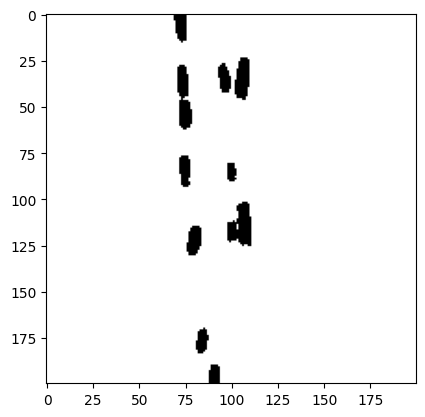

In [71]:
pred = pred_org[0] > 0.5 #.sigmoid()
plt.imshow(pred.detach().cpu().numpy(), cmap='binary')

In [19]:
valset = datamodule.val()
#trainset = datamodule.train()

is_train False


In [54]:
sample = valset[0]

In [105]:
out = model([sample],training=False)[0]

In [22]:
out['pred_masks'].shape, out['pred_query'].shape, 

(torch.Size([1, 200, 200]), torch.Size([105, 200, 200]))

In [13]:
out['pred_masks'][0]

tensor([[1.3431e-04, 2.3812e-05, 9.5258e-06,  ..., 6.4772e-04, 3.1376e-04,
         7.0676e-04],
        [2.1332e-05, 7.9570e-06, 2.0768e-06,  ..., 9.0392e-04, 4.4072e-04,
         1.3286e-04],
        [2.2425e-05, 9.2585e-06, 2.1834e-06,  ..., 1.5009e-03, 8.3781e-04,
         2.4073e-04],
        ...,
        [1.7723e-03, 7.0093e-03, 4.4688e-03,  ..., 2.1088e-04, 9.8534e-04,
         2.2766e-04],
        [1.6759e-03, 3.8668e-03, 3.5433e-03,  ..., 5.5855e-04, 1.1929e-03,
         2.6579e-04],
        [1.4173e-03, 1.5893e-03, 9.4692e-04,  ..., 6.7946e-05, 1.2916e-04,
         2.2320e-04]], device='cuda:0', grad_fn=<SelectBackward0>)

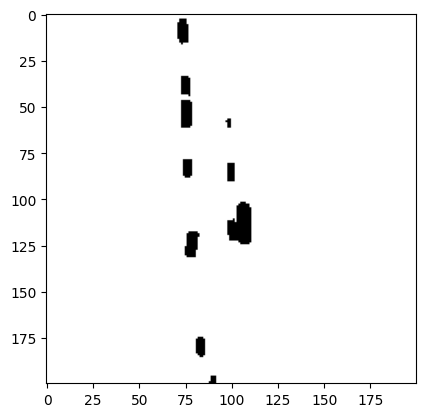

In [38]:
pred =simple_pred[0].sigmoid().round() # (preds[0]['pred_masks']> 0.5).detach().cpu()[0]
plt.imshow(pred.detach().cpu().numpy(), cmap='binary')

In [53]:
import numpy as np
import matplotlib.pyplot as plt

mask1 = sample['gt_masks'][0]*sample['gt_valid'][0]
mask2 = ( out['pred_masks'][0] > 0.5).detach().cpu().numpy()

# Create a blank image with the same shape as masks
combined_mask = np.zeros_like(mask1)

# Set combined_mask to white where both mask1 and mask2 are zero
combined_mask[(mask1 == 0) & (mask2 == 0)] = 255

# Plot mask1 in green
plt.imshow(mask1, cmap='Greens', alpha=0.5)

# Plot mask2 in red
plt.imshow(mask2, cmap='Reds', alpha=0.5)

# Combine the masks (intersection) as green + red
combined_mask[(mask1 > 0) & (mask2 > 0)] = 1
plt.imshow(combined_mask, cmap='YlGn', alpha=0.01)

# Show the plot
plt.show()

NameError: name 'sample' is not defined

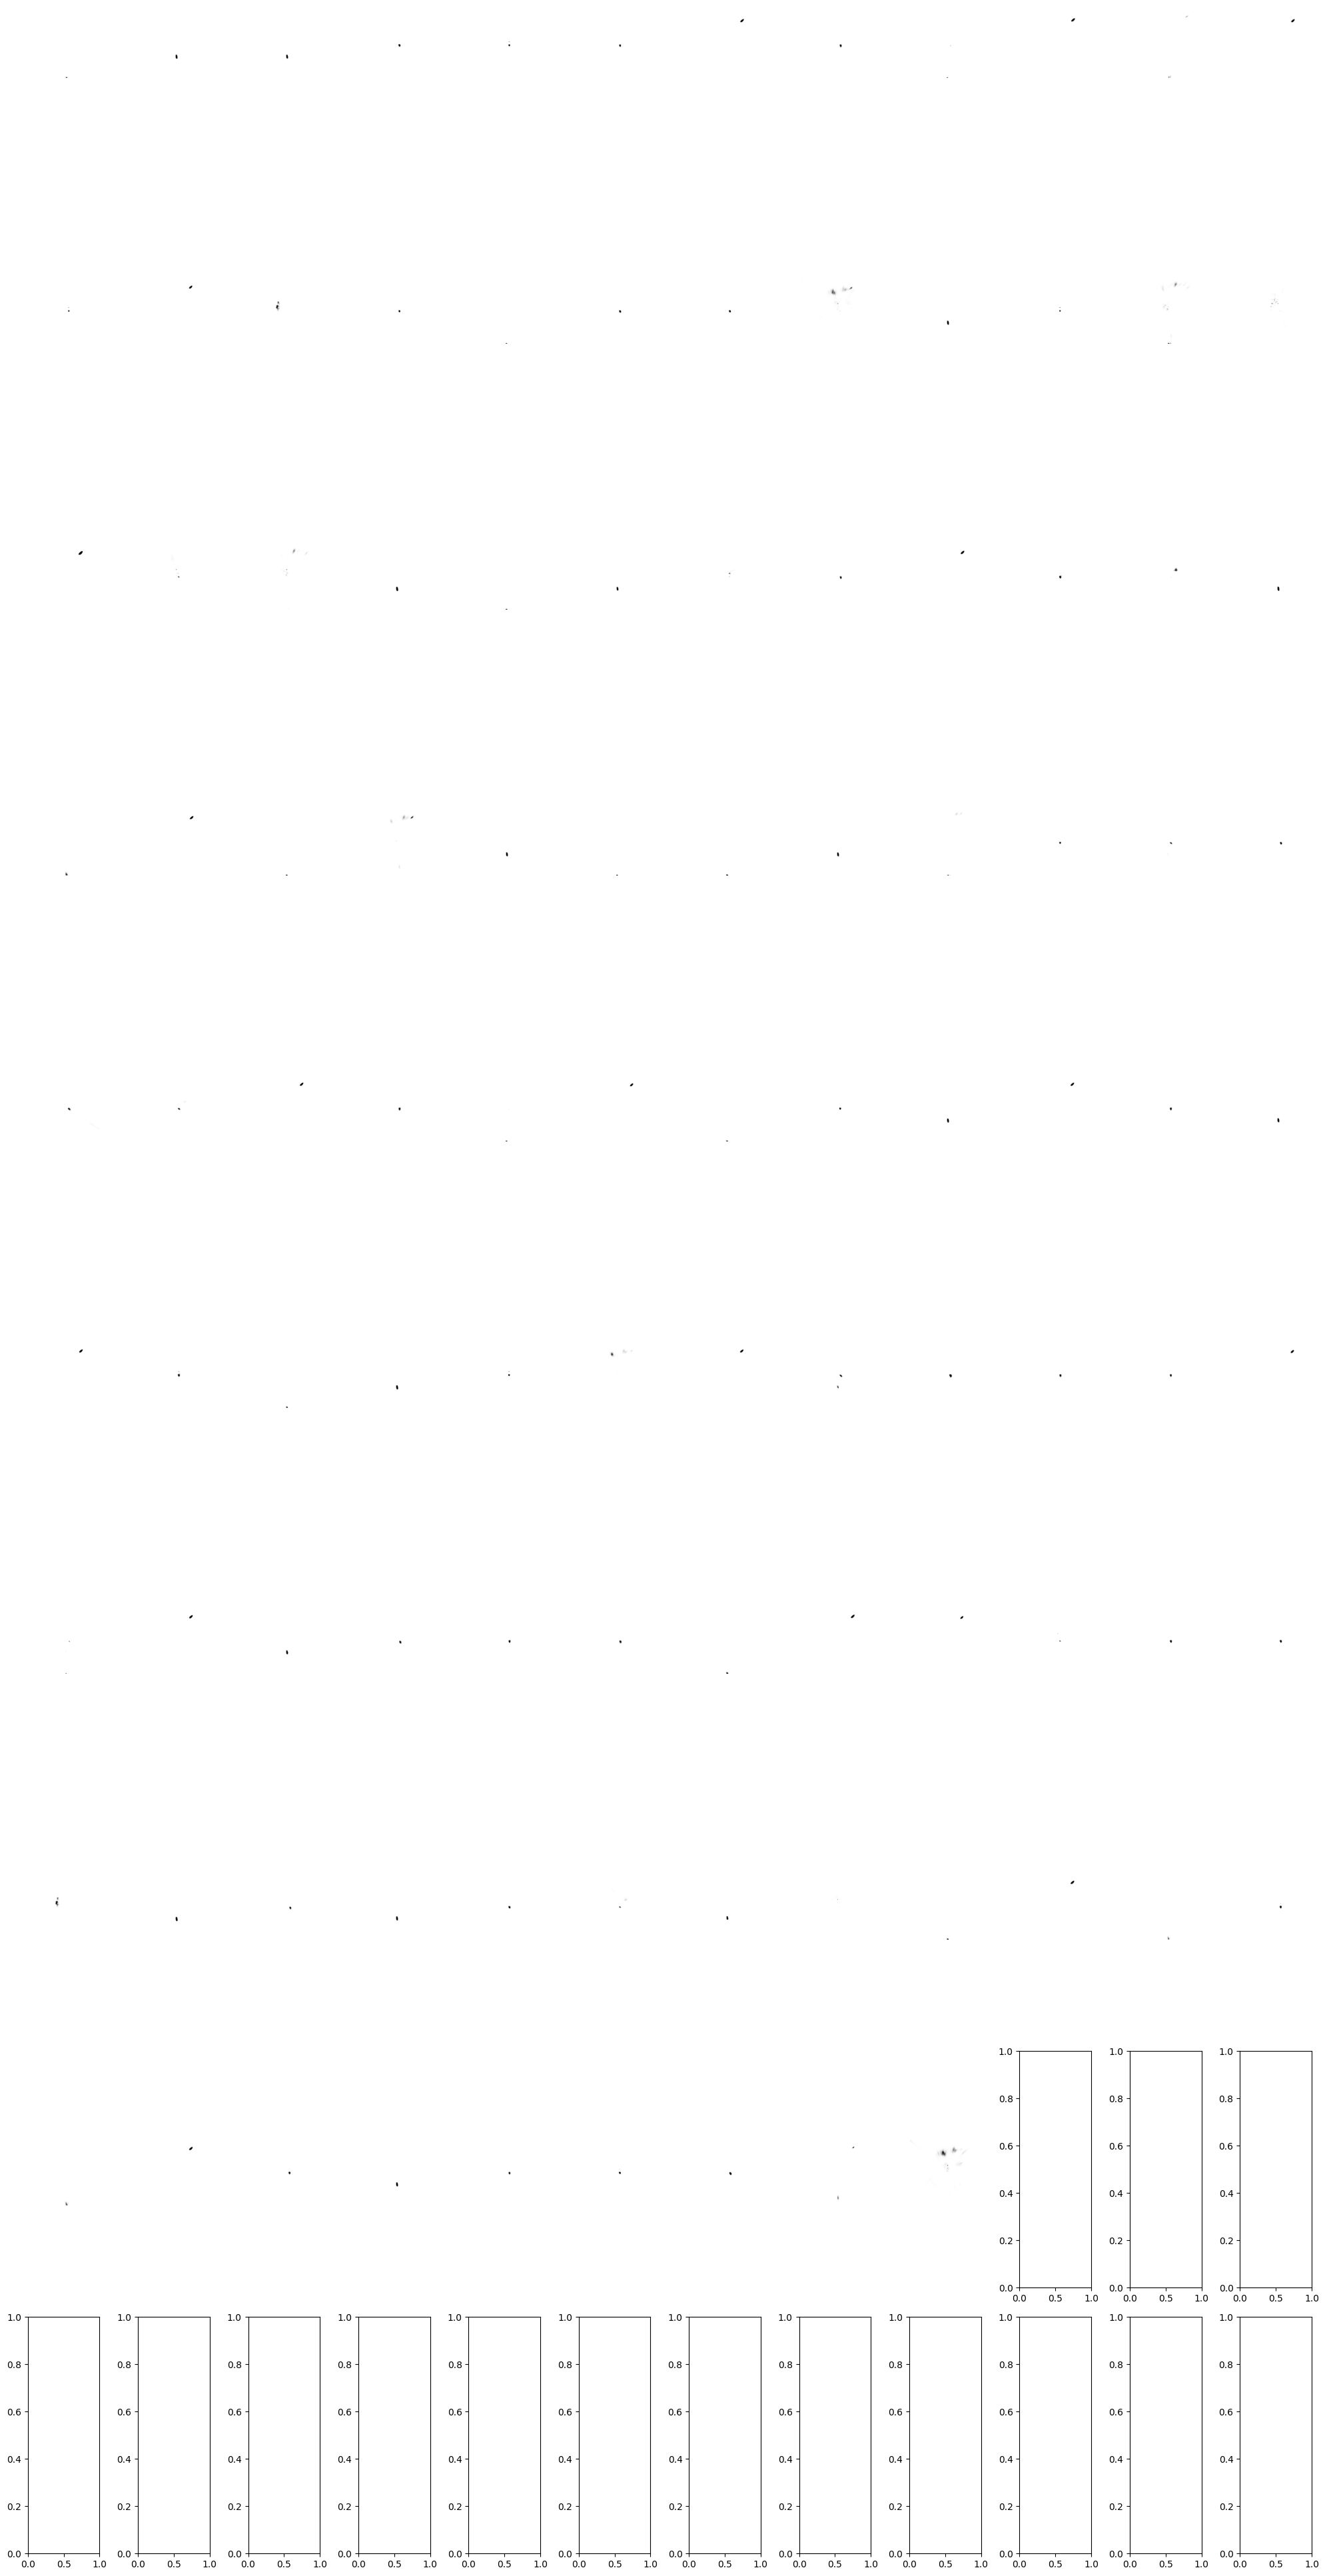

In [50]:
import matplotlib.pyplot as plt

# Assuming masks is a tensor of shape 50x200x200

# Create a figure and axes with a grid of 10x5 subplots
fig, axes = plt.subplots(10, 12, figsize=(20, 40))

# Flatten the axes array for easier iteration
axes = axes.flatten()
masks = preds[0]['pred_query']
# Iterate through the masks and plot them
for i in range(105):
    # Get the current mask
    mask = masks[i].sigmoid().detach().cpu()

    # Get the current axis
    ax = axes[i]

    # Plot the mask
    ax.imshow(mask, cmap='binary')

    # Turn off axis labels
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [34]:
out['pred_query'].shape

torch.Size([105, 200, 200])

In [77]:
def miou(pred, gt, valid):
        
    pred_round = (pred > 0.5).float()  
    if valid is None:
        valid = torch.ones_like(gt)

    intersection = (pred_round*gt*valid).sum(dim=[1,2])
    union = ((pred_round+gt)*valid).clamp(0,1).sum(dim=[1,2])
    iou = (intersection/(1e-4 + union)).mean()
    
    return iou*100

miou(pred_org[0].detach().cpu(), sample['gt_masks'], sample['gt_valid'])

tensor(38.3053)

In [61]:
total = 0

#backbone:res101-simplebev_cls:1_pts:12544_bevfeats:0_2k/best.pt --> 2.030
#backbone:res101-simplebev_cls:1_pts:12544_bevfeats:1_2k/best.pt --> 23.018


from evaluator import Evaluator

def custom_collate_fn(batch):
    # In this case, `batch` is already a list of dictionaries,
    # so you might not need to do much, depending on your requirements.
    # You could add any necessary preprocessing here.

    # For example, if you need to apply some custom transformation
    # to the images or any other data in each sample, do it here.

    # If your dataset is already prepared correctly,
    # you might just return the batch as is:
    return batch

evaluator = Evaluator() 

val_dataloader = torch.utils.data.DataLoader(valset, 
        batch_size=1, #args.batch_size // args.gpus, #1,
        collate_fn=custom_collate_fn,
        shuffle=False, 
        num_workers=6, 
        drop_last=False, 
        pin_memory=True)

model.training = False

# first epoch : 12.991

from tqdm import tqdm

val_loader = tqdm(val_dataloader)

for i, batch in enumerate(val_loader):

        preds = model(batch, training=False)  # a dictionary of losses
        
        # TODO: LOG VALIDATION LOSS
        # loss = loss_fn(all_pred_bev, all_seg_bev, all_valid_bev)
        # total_loss += loss

        for idx, pred in enumerate(preds):
            pred_masks = pred['pred_masks'].detach().cpu()
            gt_masks = batch[idx]['gt_masks'].cpu()
            valid_masks = batch[idx]['gt_valid'].cpu()

            assert pred_masks.shape == (1, 200, 200)
            assert gt_masks.shape == (1, 200, 200)
            assert valid_masks.shape == (1, 200, 200)

            # ===  Segmentation Evaluation ===
            miou = evaluator.update(pred_masks, gt_masks, valid_masks)['mIoU']
        
        metric_desc = f"mIoU: {miou * 100:.3f}"
        # === Logger ===
        val_loader.set_description(metric_desc)
    
#print(total/len(valset))
evaluator.get_results()['mIoU']

Resetting Evaluator


mIoU: 8.525:   1%|█▏                                                                                                                                                     | 48/6019 [00:15<32:25,  3.07it/s]


KeyboardInterrupt: 